<a href="https://colab.research.google.com/github/anunknownpleasure/Pricing-assets-with-deep-learning/blob/main/Asset_pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning in Asset pricing

This notebook demonstrates an approach to asset pricing using a Generative Adversarial Network (GAN) framework, following [this paper](https://economics.yale.edu/sites/default/files/deep_learning_in_asset_pricing.pdf) of Chen, Pelger and Zhu. The aim is to estimate the Stochastic Discount Factor(SDF).

We use a Generative Adversarial Network to estimate the SDF by using the no-arbitrage condition:

$$E[M_t.R^e_{t,i}] = 0$$

where $M_t$ is the SDF and $R^e_{t,i}$ is the excess return (return over the risk free rate) of asset $i$ at time $t$.  



Our approach differs from the paper in two ways:

1. The paper relies on large amount of data and requires computational resources. The paper uses 178 macro economic indicators to capture 'the state' of the economy and 46 firm specific characteristics as input data and stock data of around 10,000 stocks as test assets. To skip spending time on data cleaning and reduce computational load, we use 5 macro economic indicators and 5 Fama french factors + the risk free rate as our inputs. Our test assets will be the 25 Fama French portfolios.

2. The paper uses separate LSTM networks for Generator and Discriminator. We only use one single LSTM as a part of our Generator to capture the macro economic state and this will serve as inputs for a FeedForward Network in the generator and the discriminator




In [1]:
!git clone https://github.com/anunknownpleasure/Pricing-assets-with-deep-learning.git

fatal: destination path 'Pricing-assets-with-deep-learning' already exists and is not an empty directory.


In [28]:
import os

repository_path = '/content/Pricing-assets-with-deep-learning'
os.chdir(repository_path)

# Pull the latest changes
!git pull


remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (3/3), 295 bytes | 295.00 KiB/s, done.
From https://github.com/anunknownpleasure/Pricing-assets-with-deep-learning
   c44823c..43301a2  main       -> origin/main
Updating c44823c..43301a2
Fast-forward
 baseline_models.py | 6 ------
 1 file changed, 6 deletions(-)


## 1. Installing Libraries

This section installs the necessary Python libraries for data fetching, manipulation, and model building.
- `getFamaFrenchFactors`: To download Fama-French factor data.
- `pandas_datareader`: To download macroeconomic data from FRED and Fama-French portfolio data.
- `lxml`: A dependency for `pandas_datareader`.
- `optuna`: For hyperparameter tuning.

In [6]:
!pip install -q getFamaFrenchFactors pandas_datareader lxml optuna

## 2. Data Import and Preprocessing

In this section, we import the data, create rolling windows for LSTM, scale the data, create batches and a DataLoader object

### 2a. Importing Fama-French 5 factor data

We import the Fama-French 5 factors (Market-Risk Free, Small-Minus-Big, High-Minus-Low, Robust-Minus-Weak, Conservative-Minus-Aggressive) and the Risk-Free Rate.

In [8]:
import numpy as np
import pandas as pd
import getFamaFrenchFactors
from getFamaFrenchFactors import famaFrench5Factor


# Get the factors
factors_df = famaFrench5Factor()

# Adjust from percentage
factors_df[['Mkt-RF', 'SMB', 'HML', 'RF']] = factors_df[['Mkt-RF', 'SMB', 'HML', 'RF']] / 100



In [10]:
factors_df.head(20)

,date_ff_factors,Mkt-RF,SMB,HML,RMW,CMA,RF
0,1963-07-31,-0.000039,-0.000048,-0.000081,0.0064,-0.0115,0.000027
1,1963-08-31,0.000508,-0.000080,0.000170,0.0040,-0.0038,0.000025
2,1963-09-30,-0.000157,-0.000043,0.000000,-0.0078,0.0015,0.000027
3,1963-10-31,0.000254,-0.000134,-0.000004,0.0279,-0.0225,0.000029
4,1963-11-30,-0.000086,-0.000085,0.000173,-0.0043,0.0227,0.000027
5,1963-12-31,0.000183,-0.000189,-0.000021,0.0012,-0.0025,0.000029
6,1964-01-31,0.000227,0.000010,0.000163,0.0021,0.0148,0.000030
7,1964-02-29,0.000155,0.000033,0.000281,0.0011,0.0081,0.000026
8,1964-03-31,0.000141,0.000141,0.000329,-0.0203,0.0298,0.000031
9,1964-04-30,0.000011,-0.000148,-0.000054,-0.0132,-0.0113,0.000029


We adjust the start date to -1-31-1964

In [11]:
FFdata = factors_df.iloc[6:]
FFdata['date_ff_factors'] = pd.to_datetime(FFdata['date_ff_factors'])
FFdata = FFdata.set_index('date_ff_factors')

/tmp/ipython-input-4197135584.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FFdata['date_ff_factors'] = pd.to_datetime(FFdata['date_ff_factors'])


### 2b. Importing the macroeconomic data

Macroeconomic indicators are fetched from the FRED database. The selected indicators include measures of the term spread, default spread, industrial production, unemployment rate, and consumer sentiment.

In [12]:
import pandas_datareader.data as web

long_macro_tickers = {
    'Term_Spread': 'T10YFFM',      # 10-Yr Yield minus Fed Funds Rate
    'Default_Spread': 'AAAFFM',     # Baa Corp Yield minus Aaa Corp Yield
    'Ind_Production': 'INDPRO',     # Industrial Production Index
    'Unemployment': 'UNRATE',       # Civilian Unemployment Rate
    'Consumer_Sentiment': 'UMCSENT' # Consumer Sentiment
}


start_date = '1964-01-01'
end_date = '2025-08-31'

try:
    macro_data = web.DataReader(
        list(long_macro_tickers.values()),
        'fred',
        start=start_date,
        end=end_date
    )
    macro_data.columns = list(long_macro_tickers.keys())

except Exception as e:
    print(f"Error fetching data from FRED: {e}")
    macro_data = pd.DataFrame(index=pd.date_range(start_date, end_date, freq='M'))



# Forward-Fill any monthly gaps
macro_data = macro_data.ffill()

# Ensure all data points are at the end of the month
macro_data = macro_data.resample('ME').last()


print(f"Macro Data Imported and Aligned ({len(macro_data)} periods, starting {macro_data.index.min().strftime('%Y-%m')}):")
print(macro_data.head())
print("\n... and the tail:")
print(macro_data.tail())


Macro Data Imported and Aligned (740 periods, starting 1964-01):
            Term_Spread  Default_Spread  Ind_Production  Unemployment  \
DATE                                                                    
1964-01-31         0.69            0.91         27.7409           5.6   
1964-02-29         0.67            0.88         27.9291           5.4   
1964-03-31         0.79            0.95         27.9291           5.4   
1964-04-30         0.76            0.93         28.3861           5.3   
1964-05-31         0.70            0.91         28.5474           5.1   

            Consumer_Sentiment  
DATE                            
1964-01-31                 NaN  
1964-02-29                99.5  
1964-03-31                99.5  
1964-04-30                99.5  
1964-05-31                98.5  

... and the tail:
            Term_Spread  Default_Spread  Ind_Production  Unemployment  \
DATE                                                                    
2025-04-30        -0.05    

In [13]:
print(macro_data.shape, FFdata.shape)

(740, 5) (740, 6)


### 2c. Importing the FF-portfolios

The Fama-French 25 portfolios sorted by size and book-to-market are imported. These portfolios serve as the test assets that the learned SDF will attempt to price.

In [14]:
start_date = '1964-01-01'
end_date = '2025-08-31'

#Fetch the 25 Portfolios
ff_portfolio = web.DataReader(
    '25_Portfolios_5x5',
    'famafrench',
    start=start_date,
    end=end_date
)

df_returns_25 = ff_portfolio[0]

df_returns_25 = df_returns_25.replace([-99.99, -999], np.nan) # Since missing values are indicated by -99.99 or -999
df_returns_25.dropna(inplace=True)

df_returns_25 = (df_returns_25/100)# Converting from percentage to fraction

# Convert PeriodIndex to DatetimeIndex at the end of the month
df_returns_25.index = df_returns_25.index.to_timestamp(how = 'end').date




/tmp/ipython-input-3312524815.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_portfolio = web.DataReader(
/tmp/ipython-input-3312524815.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_portfolio = web.DataReader(
/tmp/ipython-input-3312524815.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_portfolio = web.DataReader(
/tmp/ipython-input-3312524815.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'obje

### 2d. Combining all the data into a DataFrame


In [15]:
# Making the index into a datetime object
macro_data.index = pd.to_datetime(macro_data.index)


# Combine the dataframes using merge on the index

combined_data_FF_macro = pd.merge(FFdata, macro_data, left_index=True, right_index=True, how='inner') # Combining FF and Macro

combined_data = pd.merge(combined_data_FF_macro, df_returns_25, left_index=True, right_index=True, how='inner')

combined_data.dropna(inplace=True) # Dropping NaN entries

print("Combined Data:")
display(combined_data.head())
print("\n... and the tail:")
display(combined_data.tail())

Combined Data:


,Mkt-RF,SMB,HML,RMW,CMA,RF,Term_Spread,Default_Spread,Ind_Production,Unemployment,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
date_ff_factors,,,,,,,,,,,,,,,,,,,,,
1964-02-29,0.000155,0.000033,0.000281,0.0011,0.0081,0.000026,0.67,0.88,27.9291,5.4,...,0.025943,0.015619,0.028444,0.072047,0.046121,0.018271,0.005232,0.010194,0.039989,0.037567
1964-03-31,0.000141,0.000141,0.000329,-0.0203,0.0298,0.000031,0.79,0.95,27.9291,5.4,...,0.017750,0.029767,0.052497,0.071287,0.007247,0.011575,0.007635,0.036237,0.038382,0.001491
1964-04-30,0.000011,-0.000148,-0.000054,-0.0132,-0.0113,0.000029,0.76,0.93,28.3861,5.3,...,-0.027045,0.003434,0.019784,-0.026384,-0.022805,0.002272,0.014745,0.008082,-0.009054,0.024147
1964-05-31,0.000141,-0.000062,0.000181,-0.0015,0.0013,0.000026,0.70,0.91,28.5474,5.1,...,0.011914,0.022992,0.013559,0.013281,0.040990,0.020599,0.003304,0.011776,0.042859,0.033968
1964-06-30,0.000127,0.000013,0.000068,-0.0033,0.0010,0.000030,0.67,0.91,28.6280,5.2,...,0.010927,0.014771,0.011035,0.024965,0.031119,0.009744,0.028644,0.004437,0.013682,0.024217



... and the tail:


,Mkt-RF,SMB,HML,RMW,CMA,RF,Term_Spread,Default_Spread,Ind_Production,Unemployment,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
date_ff_factors,,,,,,,,,,,,,,,,,,,,,
2025-04-30,-0.000084,-0.000186,-0.000340,-0.0285,-0.0267,0.000035,-0.05,1.12,103.6224,4.2,...,-0.008766,-0.012699,-0.020146,-0.039276,-0.072668,0.014106,-0.030129,-0.073867,-0.013472,-0.027941
2025-05-31,0.000606,-0.000072,-0.000288,0.0126,0.0251,0.000038,0.09,1.21,103.6570,4.2,...,0.062577,0.050222,0.035353,0.081175,0.065826,0.078077,0.061296,0.018407,0.026156,0.065684
2025-06-30,0.000486,-0.000002,-0.000160,-0.0319,0.0145,0.000034,0.05,1.13,104.2115,4.1,...,0.020351,0.043192,0.024175,0.073815,0.058024,0.055279,0.062451,0.047405,0.036424,0.070109
2025-07-31,0.000198,-0.000015,-0.000127,-0.0029,-0.0207,0.000034,0.06,1.12,103.8194,4.2,...,0.034206,0.021766,0.009013,-0.001069,-0.019303,0.032949,0.014068,0.012224,0.002333,-0.013744
2025-08-31,0.000185,0.000488,0.000441,-0.0069,0.0207,0.000038,-0.07,1.02,103.9203,4.3,...,0.036524,0.016164,0.023481,0.058848,0.071342,0.011610,0.011927,0.030567,0.054257,0.090799


In [16]:
combined_data.columns

Index(['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'Term_Spread',
       'Default_Spread', 'Ind_Production', 'Unemployment',
       'Consumer_Sentiment', 'SMALL LoBM', 'ME1 BM2', 'ME1 BM3', 'ME1 BM4',
       'SMALL HiBM', 'ME2 BM1', 'ME2 BM2', 'ME2 BM3', 'ME2 BM4', 'ME2 BM5',
       'ME3 BM1', 'ME3 BM2', 'ME3 BM3', 'ME3 BM4', 'ME3 BM5', 'ME4 BM1',
       'ME4 BM2', 'ME4 BM3', 'ME4 BM4', 'ME4 BM5', 'BIG LoBM', 'ME5 BM2',
       'ME5 BM3', 'ME5 BM4', 'BIG HiBM'],
      dtype='object')

In [17]:
FF_columns = combined_data.columns[:6]
macro_columns = combined_data.columns[6:11]
portfolio_columns = combined_data.columns[11:]

no_of_FF_features = len(FF_columns)
no_macro_features = len(macro_columns)
no_of_portfolios = len(portfolio_columns)




### 2e. Data Scaling

We use `StandardScaler` to scale the data to have zero mean and unit variance.

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


processed_data = scaler.fit_transform(combined_data)
processed_data[:5]

processed_data.shape


(739, 36)

### 2f. Creating rolling windows for LSTM input

A `rolling_window` function is defined to create sequential data for the LSTM layer in the Generator network. Macroeconomic data is processed into 12-month lookback windows. The Fama-French factors and portfolio returns are aligned with the end of these windows.

In [20]:
# Function to create rolling windows on a timeseries data

def rolling_window(data, lookback):
  x_rolling = []
  for i in range(len(data) - lookback):
    x_rolling.append(data[i: i + lookback])

  return np.array(x_rolling)

lookback = 12
ff_data = processed_data[:, :no_of_FF_features]
macro_data = processed_data[:, no_of_FF_features: no_of_FF_features + no_macro_features]
portfolio_data = processed_data[:, no_of_FF_features + no_macro_features:]

# Creating rolling window on macro data
X_macro_rolled = rolling_window(macro_data, lookback)

# Aligning the rolling data with FF factor and Portfolio data
X_ff_aligned = ff_data[lookback-1: -1 ]
Y_targets_aligned = portfolio_data[lookback:]




In [23]:
print("Shape of X_macro_rolled:", X_macro_rolled.shape)
print("Shape of X_ff_aligned:", X_ff_aligned.shape)
print("Shape of Y_targets_aligned:", Y_targets_aligned.shape)

Shape of X_macro_rolled: (727, 12, 5)
Shape of X_ff_aligned: (727, 6)
Shape of Y_targets_aligned: (727, 25)


### 2g. Creating Dataset and DataLoaders

Standard PyTorch process for batch creation and data loading

In [51]:
# Creating Dataset

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.data import ConcatDataset

class AssetPricingDataset(Dataset):

    def __init__(self, macro_data, ff_data, target_data):
        # Convert all data to PyTorch tensors

        self.X_macro = torch.tensor(macro_data).float()
        self.X_ff = torch.tensor(ff_data).float()
        self.Y_targets = torch.tensor(target_data).float()

    def __len__(self):
        return len(self.X_macro)

    def __getitem__(self, idx):
        return {
            'macro_X': self.X_macro[idx],    # Shape: [12, 5]
            'ff_X': self.X_ff[idx],          # Shape: [6]
            'target_Y': self.Y_targets[idx]  # Shape: [25]
        }

data = AssetPricingDataset(X_macro_rolled, X_ff_aligned, Y_targets_aligned)
no_of_samples = len(data)
train_size = int(len(data)*0.8)
val_size = int(len(data)*0.1)
test_size = no_of_samples - train_size - val_size


train_data = Subset(data, range(0, train_size))
val_data = Subset(data, range(train_size, train_size + val_size))
test_data = Subset(data, range(train_size + val_size, no_of_samples))

combined_val_test_data = Subset(data, range(train_size, no_of_samples))



BATCH_SIZE = 64

train_dataset = DataLoader(dataset = train_data, batch_size=BATCH_SIZE, shuffle = True, drop_last = True)
val_dataset = DataLoader(dataset = val_data, batch_size=BATCH_SIZE, shuffle = False, drop_last = False)
test_dataset = DataLoader(dataset = test_data, batch_size=BATCH_SIZE, shuffle = False, drop_last = False)
combined_val_test_dataset = DataLoader(dataset = combined_val_test_data, batch_size=BATCH_SIZE, shuffle = False, drop_last = False)

print("Train dataset size:", len(train_data))
print("Validation dataset size:", len(val_data))
print("Test dataset size:", len(test_data))
print("Combined Validation and Test dataset size:", len(combined_val_test_data))

Train dataset size: 581
Validation dataset size: 72
Test dataset size: 74
Combined Validation and Test dataset size: 146


# Model Architecture

This section defines the architecture of the Generator and Discriminator networks within the GAN framework.

## Generator (SDF Network)

The Generator takes macroeconomic time series (processed by an LSTM) and Fama-French factors as input. It outputs portfolio weights that define the Stochastic Discount Factor (SDF). The SDF is constructed as $M = 1 - \omega R$, where $\omega$ are the predicted weights and $R$ are the asset returns.

## Discriminator (Conditioning Network)

The Discriminator takes the hidden state from the Generator's LSTM and the Fama-French factors as input. It outputs conditioning instruments ($g$) used in the no-arbitrage pricing condition. The no-arbitrage condition states that the expected value of the product of the SDF and any asset return, conditional on information $g$, is zero: $E[R_i M | g] = 0$.

In [35]:
from model import Generator, Discriminator, GAN_loss

# Loss Function

This section defines the loss functions used to train the Generator and Discriminator networks.

- `calculate_SDF`: Computes the Stochastic Discount Factor given portfolio weights and returns.
- `no_arbitrage_loss`: Calculates the pricing errors based on the no-arbitrage condition $E[R_i M g] = 0$. The loss is the mean squared pricing error.
- `discriminator_loss`: The loss function for the Discriminator, which aims to maximize the no-arbitrage loss plus a regularization term.
- `generator_loss`: The loss function for the Generator, which aims to minimize the no-arbitrage loss plus a regularization term on the weights.

# Model Training

This section implements the training loop for the GAN. The Discriminator is trained to maximize the no-arbitrage loss, while the Generator is trained to minimize it. The training process alternates between updating the Discriminator and the Generator.

In [58]:
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

# training loop

def training(generator, discriminator, train_loader, epochs, d_lr, g_lr, D_to_G_ratio = 2, regularize = True):
  D_optim = optim.Adam(discriminator.parameters(), lr = d_lr)
  G_optim = optim.Adam(generator.parameters(), lr = g_lr)


  d_losses = []
  g_losses = []

  generator.train()
  discriminator.train()

  for epoch in range(epochs):
    epoch_g_loss = 0
    epoch_d_loss = 0
    num_batches = 0

    for batch in train_loader:
      macro_X = batch['macro_X']
      ff_X = batch['ff_X']
      returns = batch['target_Y']

    # Training the discriminator (trained twice, by default)

      for i in range(D_to_G_ratio):
        D_optim.zero_grad()

        with torch.no_grad():
          weights, h_t = generator(macro_X, ff_X)


        g_inst = discriminator(h_t, ff_X)

        # Compute discriminator loss
        d_loss = GAN_loss.discriminator_loss(weights, returns, g_inst, no_of_portfolios, regularize)

        # Backprop on discriminator
        d_loss.backward()
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)
        D_optim.step()


      # Training the generator

      G_optim.zero_grad()

      # Generate SDF weights with gradients for generator
      weights, h_t = generator(macro_X, ff_X)

      # Generate conditioning instruments without gradients for discriminator
      with torch.no_grad():
          g_inst = discriminator(h_t, ff_X)

      # Compute generator loss
      g_loss = GAN_loss.generator_loss(weights, returns, g_inst, no_of_portfolios, regularize)

      # Backprop on generator
      g_loss.backward()
      torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
      G_optim.step()

      epoch_g_loss += g_loss.item()
      epoch_d_loss += d_loss.item()
      num_batches += 1

    # Average losses in an epoch

    avg_g_loss = epoch_g_loss / num_batches
    avg_d_loss = epoch_d_loss / num_batches

    g_losses.append(avg_g_loss)
    d_losses.append(avg_d_loss)


    # Moniter the loss
    if (epoch + 1) % 50 == 0:
      print(f'Epoch [{epoch+1}/{epochs}], G Loss: {avg_g_loss:.6f}, D Loss: {avg_d_loss:.6f}')

  return g_losses, d_losses



# Evaluation

This section defines metrics and evaluates the performance of the trained models.

## 1. Evaluation metrics

The `evaluate_GAN` function calculates several metrics for the GAN model on a given dataset:
- Sharpe Ratio: Measures the risk-adjusted return of the portfolio implied by the SDF weights.
- Cross-sectional R²: Measures how well the model-implied expected returns explain the variation in average realized returns across portfolios.
- Mean Absolute Pricing Error, Max Pricing Error, Mean Squared Pricing Error: Measure the magnitude of the deviations from the no-arbitrage condition.



In [37]:
def evaluate_GAN(generator, test_loader):

    generator.eval()
    all_sdf = []
    all_returns = []
    all_predictions = []

    with torch.no_grad():
        for batch in test_loader:
            macro = batch['macro_X']
            char = batch['ff_X']
            returns = batch['target_Y']

            # Get SDF weights
            sdf_weights, _ = generator(macro, char)

            # Construct SDF
            sdf = 1 - (sdf_weights * returns).sum(dim=1)

            all_sdf.append(sdf.numpy())
            all_returns.append(returns.numpy())
            all_predictions.append(sdf_weights.numpy())

    sdf = np.concatenate(all_sdf)
    returns = np.concatenate(all_returns)
    predictions = np.concatenate(all_predictions)

    # Compute metrics
    results = {}

    # 1. Sharpe Ratio
    portfolio_returns = (predictions * returns).sum(axis=1)
    results['sharpe_ratio'] = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(12)

    # 2. Cross-sectional R²
    mean_returns = returns.mean(axis=0)
    pred_returns = predictions.mean(axis=0) @ mean_returns
    results['cross_sectional_r2'] = 1 - np.sum((mean_returns - pred_returns)**2) / np.sum((mean_returns - mean_returns.mean())**2)

    # 3. Pricing errors
    pricing_errors = (sdf.reshape(-1, 1) * returns).mean(axis=0)
    results['mean_abs_pricing_error'] = np.abs(pricing_errors).mean()
    results['max_pricing_error'] = np.abs(pricing_errors).max()
    results['mean_squared_pricing_error'] = (pricing_errors**2).mean()

    return results

## 2. Model training and Evaluation

This section trains the GAN model and evaluates its performance on the training, validation, and test datasets using the defined metrics. It also evaluates the baseline models for comparison.

Epoch [50/500], G Loss: 0.010866, D Loss: -0.004821
Epoch [100/500], G Loss: 0.024875, D Loss: -0.014716
Epoch [150/500], G Loss: 0.013958, D Loss: -0.005862
Epoch [200/500], G Loss: 0.017863, D Loss: -0.006804
Epoch [250/500], G Loss: 0.018145, D Loss: -0.005247
Epoch [300/500], G Loss: 0.010659, D Loss: -0.005144
Epoch [350/500], G Loss: 0.012520, D Loss: -0.001423
Epoch [400/500], G Loss: 0.011968, D Loss: -0.013547
Epoch [450/500], G Loss: 0.014168, D Loss: -0.005443
Epoch [500/500], G Loss: 0.019466, D Loss: -0.007045


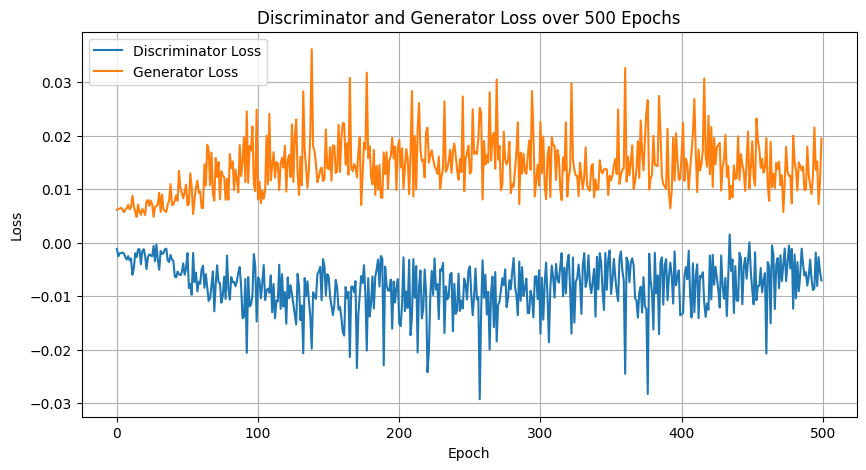

Train Sharpe Ratio: 0.3765
Train Cross-sectional R²: -0.1815
Train Mean Absolute Pricing Error: 0.021081
Train Max Pricing Error: 0.081846
Train Mean Squared Pricing Error: 0.000815
Validation Sharpe Ratio: -0.7306
Cross-sectional R²: -0.1205
Mean Absolute Pricing Error: 0.069686
Max Pricing Error: 0.139655
Mean Squared Pricing Error: 0.006446
Test Sharpe Ratio: 0.0601
Cross-sectional R²: -1.0082
Mean Absolute Pricing Error: 0.140716
Max Pricing Error: 0.291403
Mean Squared Pricing Error: 0.026242
Epoch [50/1000], G Loss: 0.011069, D Loss: -0.004358
Epoch [100/1000], G Loss: 0.011839, D Loss: -0.030163
Epoch [150/1000], G Loss: 0.015726, D Loss: -0.018688
Epoch [200/1000], G Loss: 0.046090, D Loss: -0.014203
Epoch [250/1000], G Loss: 0.030133, D Loss: -0.023377
Epoch [300/1000], G Loss: 0.052049, D Loss: -0.033308
Epoch [350/1000], G Loss: 0.020903, D Loss: -0.010074
Epoch [400/1000], G Loss: 0.009275, D Loss: 0.001030
Epoch [450/1000], G Loss: 0.030194, D Loss: -0.016973
Epoch [500/10

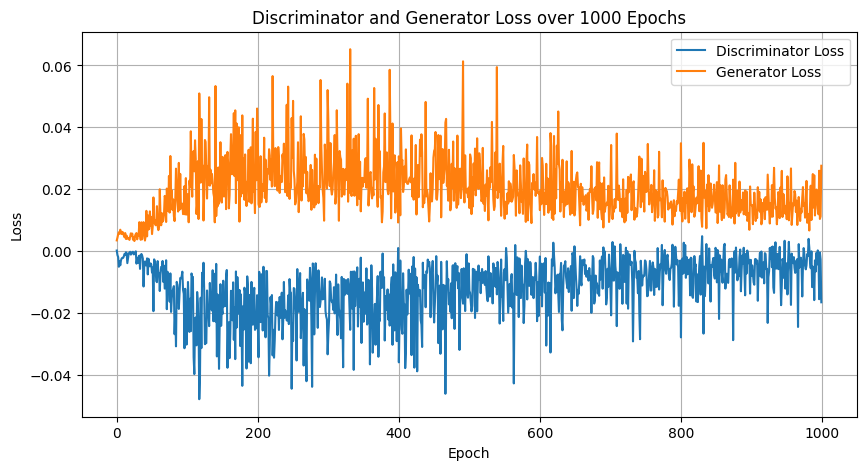

Train Sharpe Ratio: 0.5858
Train Cross-sectional R²: -0.2146
Train Mean Absolute Pricing Error: 0.026268
Train Max Pricing Error: 0.065243
Train Mean Squared Pricing Error: 0.000979
Validation Sharpe Ratio: 0.0546
Cross-sectional R²: -4.4203
Mean Absolute Pricing Error: 0.037556
Max Pricing Error: 0.112540
Mean Squared Pricing Error: 0.002234
Test Sharpe Ratio: 0.3372
Cross-sectional R²: -0.6529
Mean Absolute Pricing Error: 0.123517
Max Pricing Error: 0.252866
Mean Squared Pricing Error: 0.018864
Epoch [50/1500], G Loss: 0.008760, D Loss: -0.004181
Epoch [100/1500], G Loss: 0.021325, D Loss: -0.014272
Epoch [150/1500], G Loss: 0.014699, D Loss: -0.007551
Epoch [200/1500], G Loss: 0.028840, D Loss: -0.027512
Epoch [250/1500], G Loss: 0.011252, D Loss: -0.007140
Epoch [300/1500], G Loss: 0.015850, D Loss: -0.017257
Epoch [350/1500], G Loss: 0.018340, D Loss: -0.011826
Epoch [400/1500], G Loss: 0.015143, D Loss: -0.006341
Epoch [450/1500], G Loss: 0.015373, D Loss: -0.007858
Epoch [500/15

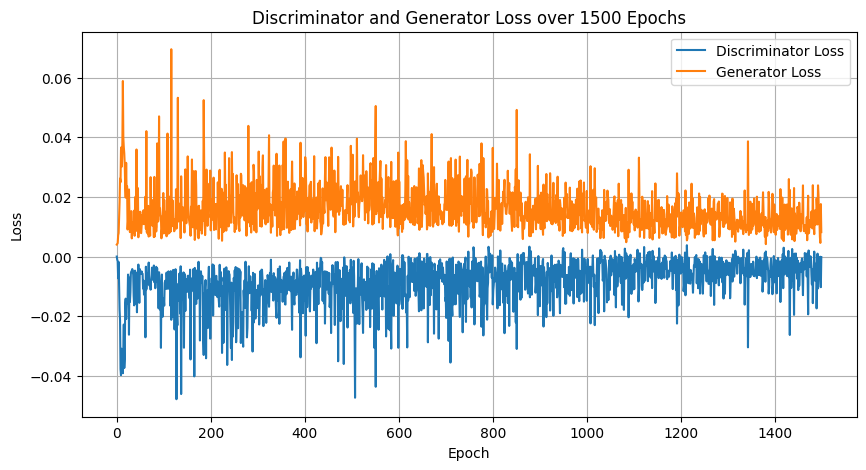

Train Sharpe Ratio: 0.8809
Train Cross-sectional R²: -1.7584
Train Mean Absolute Pricing Error: 0.017354
Train Max Pricing Error: 0.045676
Train Mean Squared Pricing Error: 0.000507
Validation Sharpe Ratio: -0.3990
Cross-sectional R²: -0.0229
Mean Absolute Pricing Error: 0.050688
Max Pricing Error: 0.108701
Mean Squared Pricing Error: 0.003221
Test Sharpe Ratio: 0.5219
Cross-sectional R²: -1.8373
Mean Absolute Pricing Error: 0.264524
Max Pricing Error: 0.485306
Mean Squared Pricing Error: 0.084824


In [39]:
# Checking the stabilization of training loss vs no of epoch
import matplotlib.pyplot as plt

macro_dim = no_macro_features
ff_dim = no_of_FF_features
num_assets = no_of_portfolios

# Hyperparameters
hidden_dim = 16
lstm_layers = 4
hidden_layer = 32
epochs = [500, 1000, 1500]
d_lr = 1e-4
g_lr = 1e-4

for epoch in epochs:

  generator = Generator(macro_dim, ff_dim, hidden_dim, lstm_layers, num_assets)

  discriminator =  Discriminator(macro_dim, ff_dim, num_assets, hidden_layer)

  g_losses, d_losses = training(generator, discriminator, train_dataset, epoch, d_lr, g_lr)

  plt.figure(figsize=(10, 5))
  plt.plot(range(epoch), d_losses, label='Discriminator Loss')
  plt.plot(range(epoch), g_losses, label='Generator Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(f'Discriminator and Generator Loss over {epoch} Epochs')
  plt.legend()
  plt.grid(True)
  plt.show()

  Gan_train = evaluate_GAN(generator, train_dataset)

  print(f"Train Sharpe Ratio: {Gan_train['sharpe_ratio']:.4f}")
  print(f"Train Cross-sectional R²: {Gan_train['cross_sectional_r2']:.4f}")
  print(f"Train Mean Absolute Pricing Error: {Gan_train['mean_abs_pricing_error']:.6f}")
  print(f"Train Max Pricing Error: {Gan_train['max_pricing_error']:.6f}")
  print(f"Train Mean Squared Pricing Error: {Gan_train['mean_squared_pricing_error']:.6f}")

  Gan_val = evaluate_GAN(generator, val_dataset)

  print(f"Validation Sharpe Ratio: {Gan_val['sharpe_ratio']:.4f}")
  print(f"Cross-sectional R²: {Gan_val['cross_sectional_r2']:.4f}")
  print(f"Mean Absolute Pricing Error: {Gan_val['mean_abs_pricing_error']:.6f}")
  print(f"Max Pricing Error: {Gan_val['max_pricing_error']:.6f}")
  print(f"Mean Squared Pricing Error: {Gan_val['mean_squared_pricing_error']:.6f}")

  Gan_test = evaluate_GAN(generator, test_dataset)

  print(f"Test Sharpe Ratio: {Gan_test['sharpe_ratio']:.4f}")
  print(f"Cross-sectional R²: {Gan_test['cross_sectional_r2']:.4f}")
  print(f"Mean Absolute Pricing Error: {Gan_test['mean_abs_pricing_error']:.6f}")
  print(f"Max Pricing Error: {Gan_test['max_pricing_error']:.6f}")
  print(f"Mean Squared Pricing Error: {Gan_test['mean_squared_pricing_error']:.6f}")





# Hyperparameter Tuning

This section uses the Optuna library to tune the hyperparameters of the Generator and Discriminator networks to maximize the Sharpe Ratio on the validation set.

In [120]:
import optuna
import torch
import numpy as np
import random

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

def objective(trial):

  macro_dim = no_macro_features
  ff_dim = no_of_FF_features
  num_assets = no_of_portfolios


  set_seed(42)


  hidden_dim = trial.suggest_categorical('hidden_dim', [8, 16, 32])
  lstm_layers = trial.suggest_categorical('lstm_layers', [2, 3, 4])
  hidden_layer = trial.suggest_categorical('hidden_layer', [16, 32, 64])
  epochs = trial.suggest_categorical('epochs', [500, 1000 ,1500])
  d_lr = trial.suggest_float('d_lr', 1e-5, 1e-3, log=True)
  g_lr = trial.suggest_float('g_lr', 1e-5, 1e-3, log=True)

  generator = Generator(macro_dim, ff_dim, hidden_dim, lstm_layers, num_assets)
  discriminator = Discriminator(macro_dim, ff_dim, num_assets, hidden_layer)

  g_losses, d_losses = training(generator, discriminator, train_dataset, epochs, d_lr, g_lr)

  Gan_val = evaluate_GAN(generator, val_dataset)

  return Gan_val['sharpe_ratio']

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params

[I 2025-11-11 06:54:33,534] A new study created in memory with name: no-name-b4d19c27-b4c9-49ae-8b79-d7f9ced15ef7


Epoch [50/1000], G Loss: 0.009247, D Loss: -0.009291
Epoch [100/1000], G Loss: 0.020256, D Loss: -0.018956
Epoch [150/1000], G Loss: 0.014619, D Loss: -0.006372
Epoch [200/1000], G Loss: 0.017790, D Loss: -0.013631
Epoch [250/1000], G Loss: 0.014959, D Loss: -0.018237
Epoch [300/1000], G Loss: 0.010806, D Loss: -0.006623
Epoch [350/1000], G Loss: 0.015195, D Loss: -0.010735
Epoch [400/1000], G Loss: 0.011673, D Loss: -0.005538
Epoch [450/1000], G Loss: 0.012267, D Loss: -0.008767
Epoch [500/1000], G Loss: 0.005854, D Loss: -0.002069
Epoch [550/1000], G Loss: 0.014387, D Loss: -0.003229
Epoch [600/1000], G Loss: 0.030399, D Loss: -0.003463
Epoch [650/1000], G Loss: 0.010034, D Loss: -0.008380
Epoch [700/1000], G Loss: 0.015699, D Loss: -0.008240
Epoch [750/1000], G Loss: 0.016200, D Loss: -0.009652
Epoch [800/1000], G Loss: 0.006078, D Loss: -0.005116
Epoch [850/1000], G Loss: 0.014525, D Loss: -0.013908
Epoch [900/1000], G Loss: 0.009979, D Loss: -0.010892
Epoch [950/1000], G Loss: 0.0

[I 2025-11-11 06:55:57,257] Trial 0 finished with value: -0.03551012355313894 and parameters: {'hidden_dim': 16, 'lstm_layers': 3, 'hidden_layer': 32, 'epochs': 1000, 'd_lr': 3.5764538329257966e-05, 'g_lr': 3.455757915835795e-05}. Best is trial 0 with value: -0.03551012355313894.


Epoch [1000/1000], G Loss: 0.005325, D Loss: -0.000823
Epoch [50/500], G Loss: 0.018012, D Loss: -0.010646
Epoch [100/500], G Loss: 0.016472, D Loss: -0.022959
Epoch [150/500], G Loss: 0.009308, D Loss: -0.007720
Epoch [200/500], G Loss: 0.016758, D Loss: -0.014435
Epoch [250/500], G Loss: 0.012593, D Loss: -0.008426
Epoch [300/500], G Loss: 0.016937, D Loss: -0.005061
Epoch [350/500], G Loss: 0.015395, D Loss: -0.005552
Epoch [400/500], G Loss: 0.013389, D Loss: -0.008657
Epoch [450/500], G Loss: 0.015999, D Loss: -0.010301


[I 2025-11-11 06:56:39,095] Trial 1 finished with value: 0.14158468433195534 and parameters: {'hidden_dim': 16, 'lstm_layers': 3, 'hidden_layer': 32, 'epochs': 500, 'd_lr': 0.0007291810286387146, 'g_lr': 0.00018352651405587989}. Best is trial 1 with value: 0.14158468433195534.


Epoch [500/500], G Loss: 0.012785, D Loss: -0.005065
Epoch [50/1500], G Loss: 0.017408, D Loss: -0.014850
Epoch [100/1500], G Loss: 0.011109, D Loss: -0.007176
Epoch [150/1500], G Loss: 0.007303, D Loss: -0.006081
Epoch [200/1500], G Loss: 0.018274, D Loss: -0.004633
Epoch [250/1500], G Loss: 0.011135, D Loss: -0.011173
Epoch [300/1500], G Loss: 0.017329, D Loss: -0.005973
Epoch [350/1500], G Loss: 0.013179, D Loss: -0.007645
Epoch [400/1500], G Loss: 0.014696, D Loss: -0.056496
Epoch [450/1500], G Loss: 0.027925, D Loss: -0.012879
Epoch [500/1500], G Loss: 0.021071, D Loss: -0.008319
Epoch [550/1500], G Loss: 0.022722, D Loss: -0.034913
Epoch [600/1500], G Loss: 0.021121, D Loss: -0.031258
Epoch [650/1500], G Loss: 0.023259, D Loss: -0.023533
Epoch [700/1500], G Loss: 0.026706, D Loss: -0.009770
Epoch [750/1500], G Loss: 0.035432, D Loss: -0.048371
Epoch [800/1500], G Loss: 0.041101, D Loss: -0.016807
Epoch [850/1500], G Loss: 0.052671, D Loss: -0.036309
Epoch [900/1500], G Loss: 0.02

[I 2025-11-11 06:59:01,074] Trial 2 finished with value: 0.3682360280912634 and parameters: {'hidden_dim': 8, 'lstm_layers': 4, 'hidden_layer': 16, 'epochs': 1500, 'd_lr': 1.9854979203367266e-05, 'g_lr': 4.66606009714706e-05}. Best is trial 2 with value: 0.3682360280912634.


Epoch [1500/1500], G Loss: 0.026075, D Loss: -0.016324
Epoch [50/500], G Loss: 0.260928, D Loss: -0.265104
Epoch [100/500], G Loss: 0.238691, D Loss: -0.240994
Epoch [150/500], G Loss: 0.172884, D Loss: -0.180696
Epoch [200/500], G Loss: 0.133599, D Loss: -0.108581
Epoch [250/500], G Loss: 0.157929, D Loss: -0.142185
Epoch [300/500], G Loss: 0.085203, D Loss: -0.068162
Epoch [350/500], G Loss: 0.091011, D Loss: -0.046161
Epoch [400/500], G Loss: 0.073242, D Loss: -0.042682
Epoch [450/500], G Loss: 0.058790, D Loss: -0.040613


[I 2025-11-11 06:59:36,197] Trial 3 finished with value: -0.4057889757475301 and parameters: {'hidden_dim': 32, 'lstm_layers': 2, 'hidden_layer': 16, 'epochs': 500, 'd_lr': 0.0004563748493313246, 'g_lr': 1.0944107164183737e-05}. Best is trial 2 with value: 0.3682360280912634.


Epoch [500/500], G Loss: 0.109131, D Loss: -0.105497
Epoch [50/1000], G Loss: 0.002222, D Loss: 0.000376
Epoch [100/1000], G Loss: 0.001491, D Loss: 0.000727
Epoch [150/1000], G Loss: 0.001153, D Loss: 0.001096
Epoch [200/1000], G Loss: 0.001057, D Loss: 0.000908
Epoch [250/1000], G Loss: 0.000772, D Loss: 0.000931
Epoch [300/1000], G Loss: 0.000796, D Loss: 0.000958
Epoch [350/1000], G Loss: 0.000592, D Loss: 0.000903
Epoch [400/1000], G Loss: 0.000790, D Loss: 0.000665
Epoch [450/1000], G Loss: 0.000471, D Loss: 0.000702
Epoch [500/1000], G Loss: 0.000425, D Loss: 0.000661
Epoch [550/1000], G Loss: 0.000425, D Loss: 0.000591
Epoch [600/1000], G Loss: 0.000425, D Loss: 0.000484
Epoch [650/1000], G Loss: 0.000362, D Loss: 0.000534
Epoch [700/1000], G Loss: 0.000397, D Loss: 0.000475
Epoch [750/1000], G Loss: 0.000384, D Loss: 0.000317
Epoch [800/1000], G Loss: 0.000490, D Loss: 0.000401
Epoch [850/1000], G Loss: 0.000691, D Loss: 0.000174
Epoch [900/1000], G Loss: 0.000349, D Loss: 0.0

[I 2025-11-11 07:00:58,813] Trial 4 finished with value: -0.5153852811538511 and parameters: {'hidden_dim': 16, 'lstm_layers': 3, 'hidden_layer': 16, 'epochs': 1000, 'd_lr': 1.0312387159109279e-05, 'g_lr': 0.0001277220960385237}. Best is trial 2 with value: 0.3682360280912634.


Epoch [1000/1000], G Loss: 0.000479, D Loss: 0.000192
Epoch [50/1500], G Loss: 0.001188, D Loss: 0.000367
Epoch [100/1500], G Loss: 0.001106, D Loss: 0.000756
Epoch [150/1500], G Loss: 0.002375, D Loss: 0.000226
Epoch [200/1500], G Loss: 0.002615, D Loss: -0.000142
Epoch [250/1500], G Loss: 0.003171, D Loss: -0.000533
Epoch [300/1500], G Loss: 0.003723, D Loss: -0.001505
Epoch [350/1500], G Loss: 0.003868, D Loss: -0.001963
Epoch [400/1500], G Loss: 0.002894, D Loss: -0.000010
Epoch [450/1500], G Loss: 0.006768, D Loss: -0.003342
Epoch [500/1500], G Loss: 0.005326, D Loss: -0.001104
Epoch [550/1500], G Loss: 0.003596, D Loss: 0.000779
Epoch [600/1500], G Loss: 0.006056, D Loss: -0.001488
Epoch [650/1500], G Loss: 0.006790, D Loss: -0.000987
Epoch [700/1500], G Loss: 0.007647, D Loss: -0.002592
Epoch [750/1500], G Loss: 0.005805, D Loss: -0.000619
Epoch [800/1500], G Loss: 0.004284, D Loss: 0.000825
Epoch [850/1500], G Loss: 0.006698, D Loss: -0.000034
Epoch [900/1500], G Loss: 0.004843

[I 2025-11-11 07:03:27,790] Trial 5 finished with value: 1.343864473579344 and parameters: {'hidden_dim': 16, 'lstm_layers': 4, 'hidden_layer': 64, 'epochs': 1500, 'd_lr': 2.9700673289763515e-05, 'g_lr': 0.0003123535377262402}. Best is trial 5 with value: 1.343864473579344.


Epoch [1500/1500], G Loss: 0.003867, D Loss: -0.001604
Epoch [50/500], G Loss: 0.017260, D Loss: -0.011730
Epoch [100/500], G Loss: 0.015456, D Loss: -0.009965
Epoch [150/500], G Loss: 0.011067, D Loss: -0.001347
Epoch [200/500], G Loss: 0.012916, D Loss: -0.002588
Epoch [250/500], G Loss: 0.005261, D Loss: 0.002665
Epoch [300/500], G Loss: 0.013093, D Loss: -0.001422
Epoch [350/500], G Loss: 0.007619, D Loss: 0.000144
Epoch [400/500], G Loss: 0.024776, D Loss: -0.012103
Epoch [450/500], G Loss: 0.012514, D Loss: -0.001850


[I 2025-11-11 07:04:09,169] Trial 6 finished with value: 0.5568613089981728 and parameters: {'hidden_dim': 16, 'lstm_layers': 3, 'hidden_layer': 16, 'epochs': 500, 'd_lr': 0.0008212983150413792, 'g_lr': 0.0004075719088045626}. Best is trial 5 with value: 1.343864473579344.


Epoch [500/500], G Loss: 0.005906, D Loss: 0.002206
Epoch [50/1000], G Loss: 0.008436, D Loss: -0.006383
Epoch [100/1000], G Loss: 0.007963, D Loss: -0.005920
Epoch [150/1000], G Loss: 0.015097, D Loss: -0.020819
Epoch [200/1000], G Loss: 0.016996, D Loss: -0.003785
Epoch [250/1000], G Loss: 0.011680, D Loss: -0.004965
Epoch [300/1000], G Loss: 0.013896, D Loss: -0.008145
Epoch [350/1000], G Loss: 0.025774, D Loss: -0.025244
Epoch [400/1000], G Loss: 0.017427, D Loss: -0.005949
Epoch [450/1000], G Loss: 0.015476, D Loss: -0.015719
Epoch [500/1000], G Loss: 0.021113, D Loss: -0.018633
Epoch [550/1000], G Loss: 0.010653, D Loss: -0.009600
Epoch [600/1000], G Loss: 0.037493, D Loss: -0.011041
Epoch [650/1000], G Loss: 0.019076, D Loss: -0.013255
Epoch [700/1000], G Loss: 0.021212, D Loss: -0.014026
Epoch [750/1000], G Loss: 0.017832, D Loss: -0.011033
Epoch [800/1000], G Loss: 0.013573, D Loss: -0.005043
Epoch [850/1000], G Loss: 0.012594, D Loss: -0.006672
Epoch [900/1000], G Loss: 0.015

[I 2025-11-11 07:05:31,130] Trial 7 finished with value: 0.0847487694272459 and parameters: {'hidden_dim': 8, 'lstm_layers': 3, 'hidden_layer': 16, 'epochs': 1000, 'd_lr': 7.681622986254388e-05, 'g_lr': 3.954184107273328e-05}. Best is trial 5 with value: 1.343864473579344.


Epoch [1000/1000], G Loss: 0.018044, D Loss: -0.012176
Epoch [50/500], G Loss: 0.088205, D Loss: -0.077904
Epoch [100/500], G Loss: 0.087760, D Loss: -0.074661
Epoch [150/500], G Loss: 0.113793, D Loss: -0.095660
Epoch [200/500], G Loss: 0.086234, D Loss: -0.114186
Epoch [250/500], G Loss: 0.074922, D Loss: -0.061634
Epoch [300/500], G Loss: 0.077148, D Loss: -0.068958
Epoch [350/500], G Loss: 0.078492, D Loss: -0.075503
Epoch [400/500], G Loss: 0.107968, D Loss: -0.083975
Epoch [450/500], G Loss: 0.093758, D Loss: -0.079954


[I 2025-11-11 07:06:12,750] Trial 8 finished with value: 0.07393427641287685 and parameters: {'hidden_dim': 8, 'lstm_layers': 3, 'hidden_layer': 32, 'epochs': 500, 'd_lr': 0.0001197102288202382, 'g_lr': 2.5157548615715465e-05}. Best is trial 5 with value: 1.343864473579344.


Epoch [500/500], G Loss: 0.093047, D Loss: -0.083999
Epoch [50/1500], G Loss: 0.086297, D Loss: -0.065438
Epoch [100/1500], G Loss: 0.038198, D Loss: -0.031017
Epoch [150/1500], G Loss: 0.014370, D Loss: -0.036907
Epoch [200/1500], G Loss: 0.022292, D Loss: -0.005355
Epoch [250/1500], G Loss: 0.013875, D Loss: -0.004560
Epoch [300/1500], G Loss: 0.033388, D Loss: -0.033558
Epoch [350/1500], G Loss: 0.028884, D Loss: -0.017798
Epoch [400/1500], G Loss: 0.029333, D Loss: -0.017866
Epoch [450/1500], G Loss: 0.021303, D Loss: -0.011722
Epoch [500/1500], G Loss: 0.016941, D Loss: -0.009050
Epoch [550/1500], G Loss: 0.013571, D Loss: -0.002096
Epoch [600/1500], G Loss: 0.030127, D Loss: -0.008720
Epoch [650/1500], G Loss: 0.020852, D Loss: -0.012619
Epoch [700/1500], G Loss: 0.025486, D Loss: -0.017148
Epoch [750/1500], G Loss: 0.019546, D Loss: -0.011034
Epoch [800/1500], G Loss: 0.016329, D Loss: -0.004220
Epoch [850/1500], G Loss: 0.009140, D Loss: -0.000090
Epoch [900/1500], G Loss: 0.01

[I 2025-11-11 07:08:15,865] Trial 9 finished with value: 0.3325497058416762 and parameters: {'hidden_dim': 8, 'lstm_layers': 3, 'hidden_layer': 16, 'epochs': 1500, 'd_lr': 0.0004001675125201962, 'g_lr': 0.00011838433656357074}. Best is trial 5 with value: 1.343864473579344.


Epoch [1500/1500], G Loss: 0.014969, D Loss: -0.006898
Epoch [50/1500], G Loss: 0.006061, D Loss: -0.002971
Epoch [100/1500], G Loss: 0.006272, D Loss: -0.004237
Epoch [150/1500], G Loss: 0.008146, D Loss: -0.005697
Epoch [200/1500], G Loss: 0.003774, D Loss: 0.001392
Epoch [250/1500], G Loss: 0.007997, D Loss: -0.001113
Epoch [300/1500], G Loss: 0.008428, D Loss: -0.000610
Epoch [350/1500], G Loss: 0.008094, D Loss: 0.000311
Epoch [400/1500], G Loss: 0.006997, D Loss: -0.001672
Epoch [450/1500], G Loss: 0.001780, D Loss: 0.003063
Epoch [500/1500], G Loss: 0.008613, D Loss: -0.003825
Epoch [550/1500], G Loss: 0.009950, D Loss: -0.002658
Epoch [600/1500], G Loss: 0.006861, D Loss: -0.000639
Epoch [650/1500], G Loss: 0.009698, D Loss: -0.004119
Epoch [700/1500], G Loss: 0.005529, D Loss: -0.001254
Epoch [750/1500], G Loss: 0.005173, D Loss: 0.001069
Epoch [800/1500], G Loss: 0.004433, D Loss: 0.000173
Epoch [850/1500], G Loss: 0.007195, D Loss: -0.001281
Epoch [900/1500], G Loss: 0.00475

[I 2025-11-11 07:10:46,414] Trial 10 finished with value: 0.22533175215231283 and parameters: {'hidden_dim': 32, 'lstm_layers': 4, 'hidden_layer': 64, 'epochs': 1500, 'd_lr': 0.00010978017876490838, 'g_lr': 0.0007323636619365146}. Best is trial 5 with value: 1.343864473579344.


Epoch [1500/1500], G Loss: 0.003697, D Loss: 0.000127
Epoch [50/500], G Loss: 0.001148, D Loss: -0.000566
Epoch [100/500], G Loss: 0.001088, D Loss: 0.000744
Epoch [150/500], G Loss: 0.002818, D Loss: 0.000061
Epoch [200/500], G Loss: 0.003795, D Loss: -0.000325
Epoch [250/500], G Loss: 0.004290, D Loss: -0.000497
Epoch [300/500], G Loss: 0.003841, D Loss: -0.000732
Epoch [350/500], G Loss: 0.005912, D Loss: -0.003101
Epoch [400/500], G Loss: 0.003960, D Loss: -0.000177
Epoch [450/500], G Loss: 0.007645, D Loss: -0.003042


[I 2025-11-11 07:11:36,108] Trial 11 finished with value: 0.641549161391887 and parameters: {'hidden_dim': 16, 'lstm_layers': 4, 'hidden_layer': 64, 'epochs': 500, 'd_lr': 4.183963588267302e-05, 'g_lr': 0.00046005217845867657}. Best is trial 5 with value: 1.343864473579344.


Epoch [500/500], G Loss: 0.007106, D Loss: -0.002321
Epoch [50/1500], G Loss: 0.002092, D Loss: -0.004581
Epoch [100/1500], G Loss: 0.002380, D Loss: 0.000267
Epoch [150/1500], G Loss: 0.003181, D Loss: -0.000777
Epoch [200/1500], G Loss: 0.002923, D Loss: -0.001234
Epoch [250/1500], G Loss: 0.002815, D Loss: -0.000268
Epoch [300/1500], G Loss: 0.003524, D Loss: -0.000344
Epoch [350/1500], G Loss: 0.006644, D Loss: -0.005386
Epoch [400/1500], G Loss: 0.004544, D Loss: 0.000156
Epoch [450/1500], G Loss: 0.005553, D Loss: -0.003062
Epoch [500/1500], G Loss: 0.005143, D Loss: -0.000856
Epoch [550/1500], G Loss: 0.007464, D Loss: -0.000937
Epoch [600/1500], G Loss: 0.004214, D Loss: -0.000306
Epoch [650/1500], G Loss: 0.003747, D Loss: -0.000103
Epoch [700/1500], G Loss: 0.013106, D Loss: -0.006755
Epoch [750/1500], G Loss: 0.007697, D Loss: -0.002467
Epoch [800/1500], G Loss: 0.007678, D Loss: -0.001642
Epoch [850/1500], G Loss: 0.006795, D Loss: -0.001528
Epoch [900/1500], G Loss: 0.0035

[I 2025-11-11 07:14:05,381] Trial 12 finished with value: 0.49345891727939634 and parameters: {'hidden_dim': 16, 'lstm_layers': 4, 'hidden_layer': 64, 'epochs': 1500, 'd_lr': 4.902550901675447e-05, 'g_lr': 0.0003292416557524034}. Best is trial 5 with value: 1.343864473579344.


Epoch [1500/1500], G Loss: 0.005612, D Loss: -0.003895
Epoch [50/500], G Loss: 0.000329, D Loss: 0.000988
Epoch [100/500], G Loss: 0.000157, D Loss: 0.000670
Epoch [150/500], G Loss: 0.000154, D Loss: 0.000409
Epoch [200/500], G Loss: 0.000253, D Loss: 0.000194
Epoch [250/500], G Loss: 0.000560, D Loss: 0.000120
Epoch [300/500], G Loss: 0.001019, D Loss: 0.000038
Epoch [350/500], G Loss: 0.003646, D Loss: -0.002773
Epoch [400/500], G Loss: 0.001902, D Loss: 0.000208
Epoch [450/500], G Loss: 0.002563, D Loss: -0.000713


[I 2025-11-11 07:14:55,105] Trial 13 finished with value: 0.5796282905114913 and parameters: {'hidden_dim': 16, 'lstm_layers': 4, 'hidden_layer': 64, 'epochs': 500, 'd_lr': 2.4618714829001554e-05, 'g_lr': 0.000901540447249421}. Best is trial 5 with value: 1.343864473579344.


Epoch [500/500], G Loss: 0.003964, D Loss: -0.001810
Epoch [50/1500], G Loss: 0.000926, D Loss: 0.001102
Epoch [100/1500], G Loss: 0.000484, D Loss: 0.000983
Epoch [150/1500], G Loss: 0.000330, D Loss: 0.000803
Epoch [200/1500], G Loss: 0.000196, D Loss: 0.000728
Epoch [250/1500], G Loss: 0.000177, D Loss: 0.000529
Epoch [300/1500], G Loss: 0.000143, D Loss: 0.000445
Epoch [350/1500], G Loss: 0.000149, D Loss: 0.000337
Epoch [400/1500], G Loss: 0.000128, D Loss: 0.000314
Epoch [450/1500], G Loss: 0.000186, D Loss: 0.000253
Epoch [500/1500], G Loss: 0.000314, D Loss: 0.000150
Epoch [550/1500], G Loss: 0.000332, D Loss: 0.000245
Epoch [600/1500], G Loss: 0.000319, D Loss: 0.000071
Epoch [650/1500], G Loss: 0.000565, D Loss: 0.000096
Epoch [700/1500], G Loss: 0.000746, D Loss: -0.000187
Epoch [750/1500], G Loss: 0.000776, D Loss: -0.000039
Epoch [800/1500], G Loss: 0.000630, D Loss: 0.000207
Epoch [850/1500], G Loss: 0.000794, D Loss: 0.000314
Epoch [900/1500], G Loss: 0.001025, D Loss: -

[I 2025-11-11 07:17:24,054] Trial 14 finished with value: 0.016927884470387136 and parameters: {'hidden_dim': 16, 'lstm_layers': 4, 'hidden_layer': 64, 'epochs': 1500, 'd_lr': 1.0698039515238475e-05, 'g_lr': 0.00034661632781337405}. Best is trial 5 with value: 1.343864473579344.


Epoch [1500/1500], G Loss: 0.001029, D Loss: 0.000569
Epoch [50/500], G Loss: 0.013521, D Loss: -0.008669
Epoch [100/500], G Loss: 0.008784, D Loss: -0.001882
Epoch [150/500], G Loss: 0.009519, D Loss: -0.004978
Epoch [200/500], G Loss: 0.008888, D Loss: -0.003040
Epoch [250/500], G Loss: 0.010955, D Loss: -0.003875
Epoch [300/500], G Loss: 0.006174, D Loss: -0.001299
Epoch [350/500], G Loss: 0.008822, D Loss: -0.002854
Epoch [400/500], G Loss: 0.010384, D Loss: -0.004405
Epoch [450/500], G Loss: 0.010007, D Loss: -0.003235


[I 2025-11-11 07:18:00,584] Trial 15 finished with value: -0.01694544465540531 and parameters: {'hidden_dim': 16, 'lstm_layers': 2, 'hidden_layer': 64, 'epochs': 500, 'd_lr': 0.00018274231991167146, 'g_lr': 0.00021432427474713943}. Best is trial 5 with value: 1.343864473579344.


Epoch [500/500], G Loss: 0.009068, D Loss: -0.005620
Epoch [50/1500], G Loss: 0.003220, D Loss: -0.001409
Epoch [100/1500], G Loss: 0.004372, D Loss: -0.002377
Epoch [150/1500], G Loss: 0.003520, D Loss: -0.002608
Epoch [200/1500], G Loss: 0.002386, D Loss: 0.000835
Epoch [250/1500], G Loss: 0.005593, D Loss: -0.001820
Epoch [300/1500], G Loss: 0.006864, D Loss: -0.000860
Epoch [350/1500], G Loss: 0.005481, D Loss: 0.000428
Epoch [400/1500], G Loss: 0.004841, D Loss: -0.000009
Epoch [450/1500], G Loss: 0.001742, D Loss: 0.002408
Epoch [500/1500], G Loss: 0.007006, D Loss: -0.001578
Epoch [550/1500], G Loss: 0.006075, D Loss: -0.001760
Epoch [600/1500], G Loss: 0.006415, D Loss: -0.001545
Epoch [650/1500], G Loss: 0.008845, D Loss: -0.004909
Epoch [700/1500], G Loss: 0.004546, D Loss: 0.000158
Epoch [750/1500], G Loss: 0.005104, D Loss: 0.000665
Epoch [800/1500], G Loss: 0.004224, D Loss: -0.000927
Epoch [850/1500], G Loss: 0.005166, D Loss: -0.000480
Epoch [900/1500], G Loss: 0.004529,

[I 2025-11-11 07:20:31,065] Trial 16 finished with value: 0.048629740086864506 and parameters: {'hidden_dim': 32, 'lstm_layers': 4, 'hidden_layer': 64, 'epochs': 1500, 'd_lr': 5.5313746869508334e-05, 'g_lr': 0.0005326030609668292}. Best is trial 5 with value: 1.343864473579344.


Epoch [1500/1500], G Loss: 0.001668, D Loss: 0.000441
Epoch [50/500], G Loss: 0.003606, D Loss: -0.006801
Epoch [100/500], G Loss: 0.005364, D Loss: -0.002096
Epoch [150/500], G Loss: 0.003655, D Loss: -0.001577
Epoch [200/500], G Loss: 0.005173, D Loss: -0.003381
Epoch [250/500], G Loss: 0.006093, D Loss: -0.004692
Epoch [300/500], G Loss: 0.017737, D Loss: -0.008545
Epoch [350/500], G Loss: 0.006186, D Loss: -0.005504
Epoch [400/500], G Loss: 0.008107, D Loss: -0.010900
Epoch [450/500], G Loss: 0.009303, D Loss: -0.003140


[I 2025-11-11 07:21:20,725] Trial 17 finished with value: 0.507034130764784 and parameters: {'hidden_dim': 16, 'lstm_layers': 4, 'hidden_layer': 64, 'epochs': 500, 'd_lr': 2.202005561336929e-05, 'g_lr': 6.523448971080333e-05}. Best is trial 5 with value: 1.343864473579344.


Epoch [500/500], G Loss: 0.006825, D Loss: -0.014155
Epoch [50/1500], G Loss: 0.002169, D Loss: -0.005418
Epoch [100/1500], G Loss: 0.002949, D Loss: 0.000084
Epoch [150/1500], G Loss: 0.002742, D Loss: -0.000605
Epoch [200/1500], G Loss: 0.003216, D Loss: -0.001649
Epoch [250/1500], G Loss: 0.002896, D Loss: -0.000902
Epoch [300/1500], G Loss: 0.003619, D Loss: -0.000465
Epoch [350/1500], G Loss: 0.005529, D Loss: -0.004557
Epoch [400/1500], G Loss: 0.003601, D Loss: -0.000635
Epoch [450/1500], G Loss: 0.006422, D Loss: -0.004500
Epoch [500/1500], G Loss: 0.004983, D Loss: -0.000209
Epoch [550/1500], G Loss: 0.009225, D Loss: -0.002084
Epoch [600/1500], G Loss: 0.005219, D Loss: -0.002418
Epoch [650/1500], G Loss: 0.004396, D Loss: 0.000719
Epoch [700/1500], G Loss: 0.015467, D Loss: -0.009131
Epoch [750/1500], G Loss: 0.008350, D Loss: -0.002431
Epoch [800/1500], G Loss: 0.010270, D Loss: -0.003013
Epoch [850/1500], G Loss: 0.007508, D Loss: -0.003164
Epoch [900/1500], G Loss: 0.0032

[I 2025-11-11 07:23:49,910] Trial 18 finished with value: 0.3525348288475552 and parameters: {'hidden_dim': 16, 'lstm_layers': 4, 'hidden_layer': 64, 'epochs': 1500, 'd_lr': 3.563787044840393e-05, 'g_lr': 0.0002179373047426322}. Best is trial 5 with value: 1.343864473579344.


Epoch [1500/1500], G Loss: 0.009634, D Loss: -0.006091
Epoch [50/1000], G Loss: 0.000964, D Loss: 0.000676
Epoch [100/1000], G Loss: 0.000878, D Loss: 0.000279
Epoch [150/1000], G Loss: 0.000701, D Loss: 0.000529
Epoch [200/1000], G Loss: 0.000783, D Loss: -0.000026
Epoch [250/1000], G Loss: 0.001055, D Loss: 0.000107
Epoch [300/1000], G Loss: 0.001898, D Loss: -0.000336
Epoch [350/1000], G Loss: 0.002392, D Loss: -0.000635
Epoch [400/1000], G Loss: 0.002348, D Loss: -0.001062
Epoch [450/1000], G Loss: 0.001147, D Loss: 0.000632
Epoch [500/1000], G Loss: 0.001625, D Loss: -0.000008
Epoch [550/1000], G Loss: 0.004019, D Loss: -0.000446
Epoch [600/1000], G Loss: 0.000860, D Loss: 0.000331
Epoch [650/1000], G Loss: 0.002132, D Loss: 0.000288
Epoch [700/1000], G Loss: 0.002355, D Loss: -0.000317
Epoch [750/1000], G Loss: 0.001007, D Loss: 0.000969
Epoch [800/1000], G Loss: 0.001533, D Loss: 0.000414
Epoch [850/1000], G Loss: 0.002790, D Loss: -0.000635
Epoch [900/1000], G Loss: 0.003657, D

[I 2025-11-11 07:25:03,831] Trial 19 finished with value: -0.06647354967706112 and parameters: {'hidden_dim': 32, 'lstm_layers': 2, 'hidden_layer': 64, 'epochs': 1000, 'd_lr': 1.4326008395099094e-05, 'g_lr': 0.0006084241207030892}. Best is trial 5 with value: 1.343864473579344.


Epoch [1000/1000], G Loss: 0.003225, D Loss: -0.001575
Epoch [50/1500], G Loss: 0.004600, D Loss: -0.002371
Epoch [100/1500], G Loss: 0.006809, D Loss: -0.000010
Epoch [150/1500], G Loss: 0.006330, D Loss: 0.000226
Epoch [200/1500], G Loss: 0.005305, D Loss: -0.002793
Epoch [250/1500], G Loss: 0.011406, D Loss: -0.008651
Epoch [300/1500], G Loss: 0.010042, D Loss: -0.001238
Epoch [350/1500], G Loss: 0.013156, D Loss: -0.005530
Epoch [400/1500], G Loss: 0.005289, D Loss: 0.000847
Epoch [450/1500], G Loss: 0.006855, D Loss: -0.000763
Epoch [500/1500], G Loss: 0.013873, D Loss: -0.006687
Epoch [550/1500], G Loss: 0.008869, D Loss: -0.000924
Epoch [600/1500], G Loss: 0.013884, D Loss: -0.005893
Epoch [650/1500], G Loss: 0.006127, D Loss: -0.000279
Epoch [700/1500], G Loss: 0.005062, D Loss: 0.000190
Epoch [750/1500], G Loss: 0.009203, D Loss: -0.003014
Epoch [800/1500], G Loss: 0.006906, D Loss: -0.000786
Epoch [850/1500], G Loss: 0.006435, D Loss: -0.000102
Epoch [900/1500], G Loss: 0.008

[I 2025-11-11 07:27:32,767] Trial 20 finished with value: 0.16799832555705532 and parameters: {'hidden_dim': 16, 'lstm_layers': 4, 'hidden_layer': 64, 'epochs': 1500, 'd_lr': 0.00021700004884757872, 'g_lr': 0.0009656692817512703}. Best is trial 5 with value: 1.343864473579344.


Epoch [1500/1500], G Loss: 0.005600, D Loss: 0.000280
Epoch [50/500], G Loss: 0.000390, D Loss: 0.000976
Epoch [100/500], G Loss: 0.000193, D Loss: 0.000666
Epoch [150/500], G Loss: 0.000272, D Loss: 0.000342
Epoch [200/500], G Loss: 0.000473, D Loss: 0.000086
Epoch [250/500], G Loss: 0.000857, D Loss: 0.000091
Epoch [300/500], G Loss: 0.001193, D Loss: 0.000191
Epoch [350/500], G Loss: 0.002589, D Loss: -0.000953
Epoch [400/500], G Loss: 0.001838, D Loss: 0.000100
Epoch [450/500], G Loss: 0.003299, D Loss: -0.001173


[I 2025-11-11 07:28:22,462] Trial 21 finished with value: 0.6779615584163136 and parameters: {'hidden_dim': 16, 'lstm_layers': 4, 'hidden_layer': 64, 'epochs': 500, 'd_lr': 2.593766034414554e-05, 'g_lr': 0.0007967325323072877}. Best is trial 5 with value: 1.343864473579344.


Epoch [500/500], G Loss: 0.003669, D Loss: -0.000792
Epoch [50/500], G Loss: 0.000782, D Loss: 0.000900
Epoch [100/500], G Loss: 0.000542, D Loss: 0.000706
Epoch [150/500], G Loss: 0.001188, D Loss: 0.000145
Epoch [200/500], G Loss: 0.001294, D Loss: 0.000117
Epoch [250/500], G Loss: 0.002326, D Loss: -0.000374
Epoch [300/500], G Loss: 0.002485, D Loss: -0.000411
Epoch [350/500], G Loss: 0.003612, D Loss: -0.001631
Epoch [400/500], G Loss: 0.002194, D Loss: 0.000755
Epoch [450/500], G Loss: 0.005919, D Loss: -0.002826


[I 2025-11-11 07:29:12,144] Trial 22 finished with value: 0.9825239104166145 and parameters: {'hidden_dim': 16, 'lstm_layers': 4, 'hidden_layer': 64, 'epochs': 500, 'd_lr': 3.2197920538529196e-05, 'g_lr': 0.0004959079836682874}. Best is trial 5 with value: 1.343864473579344.


Epoch [500/500], G Loss: 0.005839, D Loss: -0.002228
Epoch [50/500], G Loss: 0.001234, D Loss: 0.000623
Epoch [100/500], G Loss: 0.001166, D Loss: 0.000789
Epoch [150/500], G Loss: 0.002068, D Loss: 0.000327
Epoch [200/500], G Loss: 0.002174, D Loss: -0.000048
Epoch [250/500], G Loss: 0.002632, D Loss: -0.000220
Epoch [300/500], G Loss: 0.003350, D Loss: -0.002498
Epoch [350/500], G Loss: 0.003484, D Loss: -0.001839
Epoch [400/500], G Loss: 0.002746, D Loss: -0.000259
Epoch [450/500], G Loss: 0.007359, D Loss: -0.003892


[I 2025-11-11 07:30:01,873] Trial 23 finished with value: 0.472681801861292 and parameters: {'hidden_dim': 16, 'lstm_layers': 4, 'hidden_layer': 64, 'epochs': 500, 'd_lr': 2.554432327983991e-05, 'g_lr': 0.00027983507018235546}. Best is trial 5 with value: 1.343864473579344.


Epoch [500/500], G Loss: 0.005172, D Loss: -0.001108
Epoch [50/500], G Loss: 0.001383, D Loss: -0.000953
Epoch [100/500], G Loss: 0.001538, D Loss: 0.000554
Epoch [150/500], G Loss: 0.003622, D Loss: -0.000100
Epoch [200/500], G Loss: 0.004744, D Loss: 0.000391
Epoch [250/500], G Loss: 0.006922, D Loss: -0.001449
Epoch [300/500], G Loss: 0.005000, D Loss: 0.000072
Epoch [350/500], G Loss: 0.011951, D Loss: -0.007969
Epoch [400/500], G Loss: 0.004899, D Loss: 0.001050
Epoch [450/500], G Loss: 0.008288, D Loss: -0.002850


[I 2025-11-11 07:30:51,582] Trial 24 finished with value: 0.561483854296171 and parameters: {'hidden_dim': 16, 'lstm_layers': 4, 'hidden_layer': 64, 'epochs': 500, 'd_lr': 7.127546150965457e-05, 'g_lr': 0.0005898147235265936}. Best is trial 5 with value: 1.343864473579344.


Epoch [500/500], G Loss: 0.011189, D Loss: -0.004358
Epoch [50/500], G Loss: 0.002853, D Loss: 0.000520
Epoch [100/500], G Loss: 0.001461, D Loss: 0.000270
Epoch [150/500], G Loss: 0.001126, D Loss: 0.000818
Epoch [200/500], G Loss: 0.001284, D Loss: 0.000600
Epoch [250/500], G Loss: 0.000822, D Loss: 0.000560
Epoch [300/500], G Loss: 0.000679, D Loss: 0.000567
Epoch [350/500], G Loss: 0.000602, D Loss: 0.000548
Epoch [400/500], G Loss: 0.000603, D Loss: 0.000266
Epoch [450/500], G Loss: 0.000728, D Loss: 0.000050


[I 2025-11-11 07:31:40,226] Trial 25 finished with value: 0.7173335386353524 and parameters: {'hidden_dim': 16, 'lstm_layers': 4, 'hidden_layer': 32, 'epochs': 500, 'd_lr': 1.7652810559676324e-05, 'g_lr': 0.00015887775194365882}. Best is trial 5 with value: 1.343864473579344.


Epoch [500/500], G Loss: 0.000610, D Loss: 0.000013
Epoch [50/500], G Loss: 0.004499, D Loss: -0.002134
Epoch [100/500], G Loss: 0.002307, D Loss: -0.000809
Epoch [150/500], G Loss: 0.002891, D Loss: 0.000400
Epoch [200/500], G Loss: 0.002306, D Loss: 0.000518
Epoch [250/500], G Loss: 0.002070, D Loss: 0.000735
Epoch [300/500], G Loss: 0.001933, D Loss: 0.000504
Epoch [350/500], G Loss: 0.001617, D Loss: 0.000368
Epoch [400/500], G Loss: 0.002706, D Loss: -0.000894
Epoch [450/500], G Loss: 0.003384, D Loss: -0.000773


[I 2025-11-11 07:32:15,656] Trial 26 finished with value: 0.3628790973374398 and parameters: {'hidden_dim': 16, 'lstm_layers': 2, 'hidden_layer': 32, 'epochs': 500, 'd_lr': 1.5508098252348177e-05, 'g_lr': 8.610259024734972e-05}. Best is trial 5 with value: 1.343864473579344.


Epoch [500/500], G Loss: 0.001486, D Loss: 0.000469
Epoch [50/500], G Loss: 0.002752, D Loss: 0.000580
Epoch [100/500], G Loss: 0.001404, D Loss: 0.000432
Epoch [150/500], G Loss: 0.001086, D Loss: 0.000855
Epoch [200/500], G Loss: 0.000933, D Loss: 0.000700
Epoch [250/500], G Loss: 0.000798, D Loss: 0.000603
Epoch [300/500], G Loss: 0.000609, D Loss: 0.000614
Epoch [350/500], G Loss: 0.000537, D Loss: 0.000578
Epoch [400/500], G Loss: 0.000497, D Loss: 0.000398
Epoch [450/500], G Loss: 0.000678, D Loss: 0.000158


[I 2025-11-11 07:33:04,316] Trial 27 finished with value: 0.7662023559793861 and parameters: {'hidden_dim': 16, 'lstm_layers': 4, 'hidden_layer': 32, 'epochs': 500, 'd_lr': 1.5198677938025966e-05, 'g_lr': 0.0001577834981381268}. Best is trial 5 with value: 1.343864473579344.


Epoch [500/500], G Loss: 0.000468, D Loss: 0.000198
Epoch [50/1000], G Loss: 0.003855, D Loss: -0.000668
Epoch [100/1000], G Loss: 0.005330, D Loss: -0.003291
Epoch [150/1000], G Loss: 0.006359, D Loss: -0.004728
Epoch [200/1000], G Loss: 0.011677, D Loss: -0.006079
Epoch [250/1000], G Loss: 0.009292, D Loss: -0.004256
Epoch [300/1000], G Loss: 0.008368, D Loss: -0.005066
Epoch [350/1000], G Loss: 0.008813, D Loss: -0.009212
Epoch [400/1000], G Loss: 0.006439, D Loss: -0.000348
Epoch [450/1000], G Loss: 0.009382, D Loss: -0.010043
Epoch [500/1000], G Loss: 0.004392, D Loss: -0.004764
Epoch [550/1000], G Loss: 0.004302, D Loss: -0.001185
Epoch [600/1000], G Loss: 0.009476, D Loss: -0.004451
Epoch [650/1000], G Loss: 0.005121, D Loss: -0.001215
Epoch [700/1000], G Loss: 0.006460, D Loss: 0.000946
Epoch [750/1000], G Loss: 0.007896, D Loss: -0.005277
Epoch [800/1000], G Loss: 0.013498, D Loss: -0.004062
Epoch [850/1000], G Loss: 0.006574, D Loss: -0.006131
Epoch [900/1000], G Loss: 0.0103

[I 2025-11-11 07:34:42,633] Trial 28 finished with value: 0.10883394237848054 and parameters: {'hidden_dim': 32, 'lstm_layers': 4, 'hidden_layer': 32, 'epochs': 1000, 'd_lr': 3.502036558958951e-05, 'g_lr': 8.555600411740305e-05}. Best is trial 5 with value: 1.343864473579344.


Epoch [1000/1000], G Loss: 0.008230, D Loss: -0.001527
Epoch [50/1500], G Loss: 0.005940, D Loss: -0.001844
Epoch [100/1500], G Loss: 0.013144, D Loss: -0.000870
Epoch [150/1500], G Loss: 0.005826, D Loss: -0.002773
Epoch [200/1500], G Loss: 0.008281, D Loss: -0.004682
Epoch [250/1500], G Loss: 0.015266, D Loss: -0.011053
Epoch [300/1500], G Loss: 0.007193, D Loss: -0.009510
Epoch [350/1500], G Loss: 0.011945, D Loss: -0.007550
Epoch [400/1500], G Loss: 0.007185, D Loss: -0.001956
Epoch [450/1500], G Loss: 0.013166, D Loss: -0.003138
Epoch [500/1500], G Loss: 0.014037, D Loss: -0.006684
Epoch [550/1500], G Loss: 0.011655, D Loss: -0.006094
Epoch [600/1500], G Loss: 0.015306, D Loss: -0.009720
Epoch [650/1500], G Loss: 0.011416, D Loss: -0.010112
Epoch [700/1500], G Loss: 0.006763, D Loss: -0.001377
Epoch [750/1500], G Loss: 0.025389, D Loss: -0.020169
Epoch [800/1500], G Loss: 0.011001, D Loss: -0.007011
Epoch [850/1500], G Loss: 0.011497, D Loss: -0.005469
Epoch [900/1500], G Loss: 0.

[I 2025-11-11 07:37:07,584] Trial 29 finished with value: 0.08936806917203297 and parameters: {'hidden_dim': 8, 'lstm_layers': 4, 'hidden_layer': 32, 'epochs': 1500, 'd_lr': 3.1506104638226035e-05, 'g_lr': 0.0002822019433331136}. Best is trial 5 with value: 1.343864473579344.


Epoch [1500/1500], G Loss: 0.008402, D Loss: -0.002584
Epoch [50/1000], G Loss: 0.003239, D Loss: -0.000718
Epoch [100/1000], G Loss: 0.001467, D Loss: 0.000468
Epoch [150/1000], G Loss: 0.001362, D Loss: 0.000944
Epoch [200/1000], G Loss: 0.001128, D Loss: 0.000913
Epoch [250/1000], G Loss: 0.000961, D Loss: 0.000853
Epoch [300/1000], G Loss: 0.000972, D Loss: 0.000634
Epoch [350/1000], G Loss: 0.000664, D Loss: 0.000683
Epoch [400/1000], G Loss: 0.001235, D Loss: 0.000041
Epoch [450/1000], G Loss: 0.001471, D Loss: -0.000059
Epoch [500/1000], G Loss: 0.000652, D Loss: 0.000525
Epoch [550/1000], G Loss: 0.000921, D Loss: 0.000408
Epoch [600/1000], G Loss: 0.001653, D Loss: -0.000137
Epoch [650/1000], G Loss: 0.001422, D Loss: -0.000221
Epoch [700/1000], G Loss: 0.001672, D Loss: -0.000686
Epoch [750/1000], G Loss: 0.001078, D Loss: 0.000307
Epoch [800/1000], G Loss: 0.000531, D Loss: 0.000593
Epoch [850/1000], G Loss: 0.001282, D Loss: 0.000338
Epoch [900/1000], G Loss: 0.002056, D Lo

[I 2025-11-11 07:38:18,538] Trial 30 finished with value: 0.1868980787880758 and parameters: {'hidden_dim': 16, 'lstm_layers': 2, 'hidden_layer': 32, 'epochs': 1000, 'd_lr': 1.3501048814243217e-05, 'g_lr': 0.00014265275894281292}. Best is trial 5 with value: 1.343864473579344.


Epoch [1000/1000], G Loss: 0.002014, D Loss: 0.000358
Epoch [50/500], G Loss: 0.002655, D Loss: 0.000514
Epoch [100/500], G Loss: 0.001447, D Loss: 0.000172
Epoch [150/500], G Loss: 0.001070, D Loss: 0.000781
Epoch [200/500], G Loss: 0.000963, D Loss: 0.000558
Epoch [250/500], G Loss: 0.000757, D Loss: 0.000535
Epoch [300/500], G Loss: 0.000673, D Loss: 0.000529
Epoch [350/500], G Loss: 0.000586, D Loss: 0.000509
Epoch [400/500], G Loss: 0.000648, D Loss: 0.000154
Epoch [450/500], G Loss: 0.000739, D Loss: -0.000066


[I 2025-11-11 07:39:07,651] Trial 31 finished with value: 0.7232304055575836 and parameters: {'hidden_dim': 16, 'lstm_layers': 4, 'hidden_layer': 32, 'epochs': 500, 'd_lr': 1.9909795612516212e-05, 'g_lr': 0.00017129127598815397}. Best is trial 5 with value: 1.343864473579344.


Epoch [500/500], G Loss: 0.000725, D Loss: -0.000152
Epoch [50/500], G Loss: 0.007403, D Loss: -0.000622
Epoch [100/500], G Loss: 0.003875, D Loss: -0.007043
Epoch [150/500], G Loss: 0.001860, D Loss: -0.000330
Epoch [200/500], G Loss: 0.002704, D Loss: -0.002284
Epoch [250/500], G Loss: 0.002023, D Loss: -0.000496
Epoch [300/500], G Loss: 0.003151, D Loss: 0.000723
Epoch [350/500], G Loss: 0.001785, D Loss: 0.000163
Epoch [400/500], G Loss: 0.004619, D Loss: -0.002361
Epoch [450/500], G Loss: 0.002315, D Loss: -0.001478


[I 2025-11-11 07:39:56,723] Trial 32 finished with value: 0.3139928327252491 and parameters: {'hidden_dim': 16, 'lstm_layers': 4, 'hidden_layer': 32, 'epochs': 500, 'd_lr': 6.008279517061968e-05, 'g_lr': 0.0002077884861049618}. Best is trial 5 with value: 1.343864473579344.


Epoch [500/500], G Loss: 0.004141, D Loss: -0.002860
Epoch [50/500], G Loss: 0.002002, D Loss: 0.000722
Epoch [100/500], G Loss: 0.001033, D Loss: 0.000565
Epoch [150/500], G Loss: 0.000739, D Loss: 0.000815
Epoch [200/500], G Loss: 0.000593, D Loss: 0.000675
Epoch [250/500], G Loss: 0.000448, D Loss: 0.000533
Epoch [300/500], G Loss: 0.000354, D Loss: 0.000490
Epoch [350/500], G Loss: 0.000366, D Loss: 0.000445
Epoch [400/500], G Loss: 0.000300, D Loss: 0.000306
Epoch [450/500], G Loss: 0.000533, D Loss: 0.000080


[I 2025-11-11 07:40:45,586] Trial 33 finished with value: 0.48543193506792004 and parameters: {'hidden_dim': 16, 'lstm_layers': 4, 'hidden_layer': 32, 'epochs': 500, 'd_lr': 1.8248496500129603e-05, 'g_lr': 0.00023712938482661742}. Best is trial 5 with value: 1.343864473579344.


Epoch [500/500], G Loss: 0.000342, D Loss: 0.000075
Epoch [50/500], G Loss: 0.005408, D Loss: -0.000901
Epoch [100/500], G Loss: 0.003980, D Loss: -0.001765
Epoch [150/500], G Loss: 0.002778, D Loss: 0.000114
Epoch [200/500], G Loss: 0.010209, D Loss: -0.000165
Epoch [250/500], G Loss: 0.004246, D Loss: -0.003072
Epoch [300/500], G Loss: 0.003856, D Loss: 0.000213
Epoch [350/500], G Loss: 0.004488, D Loss: 0.000229
Epoch [400/500], G Loss: 0.005746, D Loss: -0.002469
Epoch [450/500], G Loss: 0.004125, D Loss: -0.004519


[I 2025-11-11 07:41:35,489] Trial 34 finished with value: 0.7178310438735084 and parameters: {'hidden_dim': 16, 'lstm_layers': 4, 'hidden_layer': 32, 'epochs': 500, 'd_lr': 2.932630798398728e-05, 'g_lr': 6.162277007971283e-05}. Best is trial 5 with value: 1.343864473579344.


Epoch [500/500], G Loss: 0.005440, D Loss: -0.003882
Epoch [50/500], G Loss: 0.002380, D Loss: 0.000674
Epoch [100/500], G Loss: 0.001250, D Loss: 0.000595
Epoch [150/500], G Loss: 0.000946, D Loss: 0.000889
Epoch [200/500], G Loss: 0.000798, D Loss: 0.000765
Epoch [250/500], G Loss: 0.000656, D Loss: 0.000651
Epoch [300/500], G Loss: 0.000484, D Loss: 0.000644
Epoch [350/500], G Loss: 0.000424, D Loss: 0.000578
Epoch [400/500], G Loss: 0.000382, D Loss: 0.000457
Epoch [450/500], G Loss: 0.000568, D Loss: 0.000246


[I 2025-11-11 07:42:24,771] Trial 35 finished with value: 0.7324658949941799 and parameters: {'hidden_dim': 16, 'lstm_layers': 4, 'hidden_layer': 32, 'epochs': 500, 'd_lr': 1.3411187657578117e-05, 'g_lr': 0.0001757688254008514}. Best is trial 5 with value: 1.343864473579344.


Epoch [500/500], G Loss: 0.000342, D Loss: 0.000276
Epoch [50/500], G Loss: 0.001074, D Loss: 0.000983
Epoch [100/500], G Loss: 0.000524, D Loss: 0.000917
Epoch [150/500], G Loss: 0.000359, D Loss: 0.000880
Epoch [200/500], G Loss: 0.000265, D Loss: 0.000747
Epoch [250/500], G Loss: 0.000194, D Loss: 0.000599
Epoch [300/500], G Loss: 0.000131, D Loss: 0.000560
Epoch [350/500], G Loss: 0.000200, D Loss: 0.000426
Epoch [400/500], G Loss: 0.000119, D Loss: 0.000421
Epoch [450/500], G Loss: 0.000219, D Loss: 0.000274


[I 2025-11-11 07:43:13,863] Trial 36 finished with value: 0.3591185658104092 and parameters: {'hidden_dim': 16, 'lstm_layers': 4, 'hidden_layer': 32, 'epochs': 500, 'd_lr': 1.2166425597408105e-05, 'g_lr': 0.000413459727467434}. Best is trial 5 with value: 1.343864473579344.


Epoch [500/500], G Loss: 0.000139, D Loss: 0.000271
Epoch [50/500], G Loss: 0.008235, D Loss: -0.005100
Epoch [100/500], G Loss: 0.011809, D Loss: -0.000555
Epoch [150/500], G Loss: 0.004610, D Loss: -0.000181
Epoch [200/500], G Loss: 0.005574, D Loss: -0.003600
Epoch [250/500], G Loss: 0.006485, D Loss: -0.001683
Epoch [300/500], G Loss: 0.006462, D Loss: -0.008638
Epoch [350/500], G Loss: 0.007114, D Loss: -0.013207
Epoch [400/500], G Loss: 0.004830, D Loss: -0.000809
Epoch [450/500], G Loss: 0.010574, D Loss: -0.001313


[I 2025-11-11 07:44:02,661] Trial 37 finished with value: 0.4425584739586721 and parameters: {'hidden_dim': 8, 'lstm_layers': 4, 'hidden_layer': 32, 'epochs': 500, 'd_lr': 1.0131578005449252e-05, 'g_lr': 0.00010826100486965923}. Best is trial 5 with value: 1.343864473579344.


Epoch [500/500], G Loss: 0.009809, D Loss: -0.001523
Epoch [50/1500], G Loss: 0.004884, D Loss: -0.002590
Epoch [100/1500], G Loss: 0.009678, D Loss: -0.006937
Epoch [150/1500], G Loss: 0.008445, D Loss: -0.005017
Epoch [200/1500], G Loss: 0.006155, D Loss: -0.003110
Epoch [250/1500], G Loss: 0.011752, D Loss: -0.006471
Epoch [300/1500], G Loss: 0.007113, D Loss: -0.006257
Epoch [350/1500], G Loss: 0.010283, D Loss: -0.003948
Epoch [400/1500], G Loss: 0.009461, D Loss: -0.012474
Epoch [450/1500], G Loss: 0.008074, D Loss: -0.003213
Epoch [500/1500], G Loss: 0.009850, D Loss: -0.010211
Epoch [550/1500], G Loss: 0.007504, D Loss: -0.004518
Epoch [600/1500], G Loss: 0.007920, D Loss: -0.008084
Epoch [650/1500], G Loss: 0.019466, D Loss: -0.018368
Epoch [700/1500], G Loss: 0.006658, D Loss: -0.006311
Epoch [750/1500], G Loss: 0.016232, D Loss: -0.011160
Epoch [800/1500], G Loss: 0.011390, D Loss: -0.003408
Epoch [850/1500], G Loss: 0.009540, D Loss: -0.002902
Epoch [900/1500], G Loss: 0.01

[I 2025-11-11 07:46:07,682] Trial 38 finished with value: -0.08111323363939302 and parameters: {'hidden_dim': 16, 'lstm_layers': 3, 'hidden_layer': 16, 'epochs': 1500, 'd_lr': 4.070026815822061e-05, 'g_lr': 1.814650148083025e-05}. Best is trial 5 with value: 1.343864473579344.


Epoch [1500/1500], G Loss: 0.015177, D Loss: -0.011751
Epoch [50/1000], G Loss: 0.000625, D Loss: 0.000963
Epoch [100/1000], G Loss: 0.000234, D Loss: 0.000813
Epoch [150/1000], G Loss: 0.000136, D Loss: 0.000668
Epoch [200/1000], G Loss: 0.000096, D Loss: 0.000488
Epoch [250/1000], G Loss: 0.000081, D Loss: 0.000362
Epoch [300/1000], G Loss: 0.000076, D Loss: 0.000280
Epoch [350/1000], G Loss: 0.000093, D Loss: 0.000220
Epoch [400/1000], G Loss: 0.000074, D Loss: 0.000199
Epoch [450/1000], G Loss: 0.000112, D Loss: 0.000110
Epoch [500/1000], G Loss: 0.000211, D Loss: 0.000074
Epoch [550/1000], G Loss: 0.000211, D Loss: 0.000064
Epoch [600/1000], G Loss: 0.000107, D Loss: 0.000156
Epoch [650/1000], G Loss: 0.000254, D Loss: -0.000038
Epoch [700/1000], G Loss: 0.000279, D Loss: 0.000035
Epoch [750/1000], G Loss: 0.000184, D Loss: 0.000073
Epoch [800/1000], G Loss: 0.000241, D Loss: 0.000062
Epoch [850/1000], G Loss: 0.000158, D Loss: 0.000009
Epoch [900/1000], G Loss: 0.000139, D Loss: 

[I 2025-11-11 07:47:19,682] Trial 39 finished with value: -0.2501241395363666 and parameters: {'hidden_dim': 32, 'lstm_layers': 2, 'hidden_layer': 32, 'epochs': 1000, 'd_lr': 1.6436437493230896e-05, 'g_lr': 0.0003549883300799782}. Best is trial 5 with value: 1.343864473579344.


Epoch [1000/1000], G Loss: 0.000254, D Loss: 0.000036
Epoch [50/500], G Loss: 0.001494, D Loss: 0.000967
Epoch [100/500], G Loss: 0.001102, D Loss: 0.000824
Epoch [150/500], G Loss: 0.000720, D Loss: 0.000776
Epoch [200/500], G Loss: 0.000602, D Loss: 0.000782
Epoch [250/500], G Loss: 0.000524, D Loss: 0.000660
Epoch [300/500], G Loss: 0.000788, D Loss: 0.000246
Epoch [350/500], G Loss: 0.000554, D Loss: 0.000247
Epoch [400/500], G Loss: 0.000661, D Loss: 0.000189
Epoch [450/500], G Loss: 0.000879, D Loss: -0.000144


[I 2025-11-11 07:48:00,877] Trial 40 finished with value: 0.0224327153421385 and parameters: {'hidden_dim': 8, 'lstm_layers': 3, 'hidden_layer': 16, 'epochs': 500, 'd_lr': 2.118421763374803e-05, 'g_lr': 0.0002896532697166413}. Best is trial 5 with value: 1.343864473579344.


Epoch [500/500], G Loss: 0.000865, D Loss: 0.000027
Epoch [50/500], G Loss: 0.002962, D Loss: 0.000454
Epoch [100/500], G Loss: 0.001504, D Loss: 0.000055
Epoch [150/500], G Loss: 0.001126, D Loss: 0.000772
Epoch [200/500], G Loss: 0.001013, D Loss: 0.000502
Epoch [250/500], G Loss: 0.000805, D Loss: 0.000522
Epoch [300/500], G Loss: 0.000759, D Loss: 0.000518
Epoch [350/500], G Loss: 0.000664, D Loss: 0.000491
Epoch [400/500], G Loss: 0.000767, D Loss: 0.000055
Epoch [450/500], G Loss: 0.000797, D Loss: -0.000109


[I 2025-11-11 07:48:49,754] Trial 41 finished with value: 0.640887300822927 and parameters: {'hidden_dim': 16, 'lstm_layers': 4, 'hidden_layer': 32, 'epochs': 500, 'd_lr': 2.1048333673878044e-05, 'g_lr': 0.00016676121245288577}. Best is trial 5 with value: 1.343864473579344.


Epoch [500/500], G Loss: 0.000856, D Loss: -0.000287
Epoch [50/500], G Loss: 0.002887, D Loss: 0.000547
Epoch [100/500], G Loss: 0.001525, D Loss: 0.000424
Epoch [150/500], G Loss: 0.001227, D Loss: 0.000868
Epoch [200/500], G Loss: 0.001635, D Loss: 0.000678
Epoch [250/500], G Loss: 0.000979, D Loss: 0.000592
Epoch [300/500], G Loss: 0.000712, D Loss: 0.000648
Epoch [350/500], G Loss: 0.000627, D Loss: 0.000637
Epoch [400/500], G Loss: 0.000597, D Loss: 0.000444
Epoch [450/500], G Loss: 0.000757, D Loss: 0.000214


[I 2025-11-11 07:49:38,590] Trial 42 finished with value: 0.7373386898662164 and parameters: {'hidden_dim': 16, 'lstm_layers': 4, 'hidden_layer': 32, 'epochs': 500, 'd_lr': 1.3771712390449166e-05, 'g_lr': 0.00013586280921325974}. Best is trial 5 with value: 1.343864473579344.


Epoch [500/500], G Loss: 0.000528, D Loss: 0.000273
Epoch [50/500], G Loss: 0.002993, D Loss: 0.000517
Epoch [100/500], G Loss: 0.001614, D Loss: 0.000394
Epoch [150/500], G Loss: 0.001327, D Loss: 0.000859
Epoch [200/500], G Loss: 0.001788, D Loss: 0.000683
Epoch [250/500], G Loss: 0.001115, D Loss: 0.000563
Epoch [300/500], G Loss: 0.000795, D Loss: 0.000671
Epoch [350/500], G Loss: 0.000710, D Loss: 0.000664
Epoch [400/500], G Loss: 0.000680, D Loss: 0.000465
Epoch [450/500], G Loss: 0.000835, D Loss: 0.000218


[I 2025-11-11 07:50:27,545] Trial 43 finished with value: 0.7038594986576204 and parameters: {'hidden_dim': 16, 'lstm_layers': 4, 'hidden_layer': 32, 'epochs': 500, 'd_lr': 1.3227343493919384e-05, 'g_lr': 0.00012229196894137257}. Best is trial 5 with value: 1.343864473579344.


Epoch [500/500], G Loss: 0.000586, D Loss: 0.000301
Epoch [50/500], G Loss: 0.033854, D Loss: -0.019956
Epoch [100/500], G Loss: 0.017218, D Loss: -0.049425
Epoch [150/500], G Loss: 0.015718, D Loss: -0.003540
Epoch [200/500], G Loss: 0.058539, D Loss: -0.002276
Epoch [250/500], G Loss: 0.010412, D Loss: -0.020002
Epoch [300/500], G Loss: 0.015268, D Loss: -0.000859
Epoch [350/500], G Loss: 0.006035, D Loss: -0.001680
Epoch [400/500], G Loss: 0.009063, D Loss: -0.003676
Epoch [450/500], G Loss: 0.011370, D Loss: -0.013285


[I 2025-11-11 07:51:16,713] Trial 44 finished with value: 0.4757919064581105 and parameters: {'hidden_dim': 16, 'lstm_layers': 4, 'hidden_layer': 32, 'epochs': 500, 'd_lr': 8.993250610521406e-05, 'g_lr': 8.785689014058546e-05}. Best is trial 5 with value: 1.343864473579344.


Epoch [500/500], G Loss: 0.010462, D Loss: -0.004864
Epoch [50/500], G Loss: 0.003720, D Loss: 0.000328
Epoch [100/500], G Loss: 0.002322, D Loss: -0.000041
Epoch [150/500], G Loss: 0.002043, D Loss: 0.000635
Epoch [200/500], G Loss: 0.006215, D Loss: 0.000565
Epoch [250/500], G Loss: 0.002537, D Loss: -0.000208
Epoch [300/500], G Loss: 0.001721, D Loss: 0.000660
Epoch [350/500], G Loss: 0.002103, D Loss: 0.000685
Epoch [400/500], G Loss: 0.001776, D Loss: 0.000140
Epoch [450/500], G Loss: 0.001932, D Loss: -0.000525


[I 2025-11-11 07:52:06,162] Trial 45 finished with value: 0.6863532814467159 and parameters: {'hidden_dim': 16, 'lstm_layers': 4, 'hidden_layer': 32, 'epochs': 500, 'd_lr': 1.1956100572818317e-05, 'g_lr': 5.761356693479978e-05}. Best is trial 5 with value: 1.343864473579344.


Epoch [500/500], G Loss: 0.001597, D Loss: -0.000023
Epoch [50/1500], G Loss: 0.006301, D Loss: -0.001307
Epoch [100/1500], G Loss: 0.003551, D Loss: -0.003957
Epoch [150/1500], G Loss: 0.009568, D Loss: 0.000254
Epoch [200/1500], G Loss: 0.002772, D Loss: -0.001126
Epoch [250/1500], G Loss: 0.002508, D Loss: -0.000420
Epoch [300/1500], G Loss: 0.004434, D Loss: -0.002713
Epoch [350/1500], G Loss: 0.004011, D Loss: -0.002065
Epoch [400/1500], G Loss: 0.006453, D Loss: -0.001611
Epoch [450/1500], G Loss: 0.003472, D Loss: -0.002126
Epoch [500/1500], G Loss: 0.006017, D Loss: -0.001510
Epoch [550/1500], G Loss: 0.003830, D Loss: -0.001531
Epoch [600/1500], G Loss: 0.005775, D Loss: -0.002303
Epoch [650/1500], G Loss: 0.006835, D Loss: -0.000162
Epoch [700/1500], G Loss: 0.005420, D Loss: -0.003010
Epoch [750/1500], G Loss: 0.005579, D Loss: -0.000671
Epoch [800/1500], G Loss: 0.007001, D Loss: -0.002274
Epoch [850/1500], G Loss: 0.005614, D Loss: -0.002350
Epoch [900/1500], G Loss: 0.004

[I 2025-11-11 07:54:31,442] Trial 46 finished with value: 0.08800098150701138 and parameters: {'hidden_dim': 16, 'lstm_layers': 4, 'hidden_layer': 16, 'epochs': 1500, 'd_lr': 4.321803297705409e-05, 'g_lr': 0.0001413441598674667}. Best is trial 5 with value: 1.343864473579344.


Epoch [1500/1500], G Loss: 0.005609, D Loss: 0.000495
Epoch [50/500], G Loss: 0.000944, D Loss: 0.000790
Epoch [100/500], G Loss: 0.000803, D Loss: 0.000400
Epoch [150/500], G Loss: 0.000937, D Loss: -0.000247
Epoch [200/500], G Loss: 0.001490, D Loss: -0.000124
Epoch [250/500], G Loss: 0.001199, D Loss: 0.000625
Epoch [300/500], G Loss: 0.003043, D Loss: -0.001820
Epoch [350/500], G Loss: 0.002703, D Loss: -0.000246
Epoch [400/500], G Loss: 0.002820, D Loss: -0.000602
Epoch [450/500], G Loss: 0.003197, D Loss: -0.000547


[I 2025-11-11 07:55:14,802] Trial 47 finished with value: 0.050016133308959154 and parameters: {'hidden_dim': 16, 'lstm_layers': 3, 'hidden_layer': 64, 'epochs': 500, 'd_lr': 2.8544982553918625e-05, 'g_lr': 0.00048553284746750904}. Best is trial 5 with value: 1.343864473579344.


Epoch [500/500], G Loss: 0.002961, D Loss: -0.001081
Epoch [50/1500], G Loss: 0.049200, D Loss: -0.020212
Epoch [100/1500], G Loss: 0.038828, D Loss: -0.046320
Epoch [150/1500], G Loss: 0.011775, D Loss: -0.004702
Epoch [200/1500], G Loss: 0.062307, D Loss: -0.013463
Epoch [250/1500], G Loss: 0.019021, D Loss: -0.013266
Epoch [300/1500], G Loss: 0.026753, D Loss: -0.005354
Epoch [350/1500], G Loss: 0.010883, D Loss: -0.004448
Epoch [400/1500], G Loss: 0.010347, D Loss: -0.001997
Epoch [450/1500], G Loss: 0.019924, D Loss: -0.014489
Epoch [500/1500], G Loss: 0.014218, D Loss: -0.004391
Epoch [550/1500], G Loss: 0.012560, D Loss: -0.001842
Epoch [600/1500], G Loss: 0.010106, D Loss: -0.005555
Epoch [650/1500], G Loss: 0.018418, D Loss: -0.009875
Epoch [700/1500], G Loss: 0.008519, D Loss: -0.003795
Epoch [750/1500], G Loss: 0.010591, D Loss: -0.001011
Epoch [800/1500], G Loss: 0.012074, D Loss: -0.004729
Epoch [850/1500], G Loss: 0.007350, D Loss: -0.003140
Epoch [900/1500], G Loss: 0.00

[I 2025-11-11 07:57:41,358] Trial 48 finished with value: -0.17157184095233252 and parameters: {'hidden_dim': 16, 'lstm_layers': 4, 'hidden_layer': 32, 'epochs': 1500, 'd_lr': 0.0006346481008260411, 'g_lr': 0.00019106382882610846}. Best is trial 5 with value: 1.343864473579344.


Epoch [1500/1500], G Loss: 0.005359, D Loss: 0.002475
Epoch [50/500], G Loss: 0.004279, D Loss: -0.005430
Epoch [100/500], G Loss: 0.007082, D Loss: 0.000123
Epoch [150/500], G Loss: 0.006321, D Loss: -0.000390
Epoch [200/500], G Loss: 0.003498, D Loss: -0.000258
Epoch [250/500], G Loss: 0.008151, D Loss: -0.002382
Epoch [300/500], G Loss: 0.002772, D Loss: -0.001535
Epoch [350/500], G Loss: 0.006491, D Loss: -0.001091
Epoch [400/500], G Loss: 0.004838, D Loss: -0.001692
Epoch [450/500], G Loss: 0.003847, D Loss: -0.000675


[I 2025-11-11 07:58:30,798] Trial 49 finished with value: 0.16388177684517705 and parameters: {'hidden_dim': 8, 'lstm_layers': 4, 'hidden_layer': 64, 'epochs': 500, 'd_lr': 1.5575332975041673e-05, 'g_lr': 0.0002696255837813219}. Best is trial 5 with value: 1.343864473579344.


Epoch [500/500], G Loss: 0.003131, D Loss: -0.001281


In [121]:
print(best_params)

{'hidden_dim': 16, 'lstm_layers': 4, 'hidden_layer': 64, 'epochs': 1500, 'd_lr': 2.9700673289763515e-05, 'g_lr': 0.0003123535377262402}


Here are some of the top hyperparameter combinations from the Optuna tuning:

| Trial # | Value (Sharpe Ratio) | hidden_dim | lstm_layers | hidden_layer | epochs | d_lr   | g_lr   |
|---------|----------------------|------------|-------------|--------------|--------|--------|--------|
| 5       | 1.3439               | 16         | 4           | 64           | 1500   | 2.97e-05 | 3.12e-04 |
| 22      | 0.9825               | 16         | 4           | 64           | 500    | 3.22e-05 | 4.96e-04 |
| 27      | 0.7662               | 16         | 4           | 32           | 500    | 1.52e-05 | 1.58e-04 |
| 42      | 0.7373               | 16         | 4           | 32           | 500    | 1.38e-05 | 1.36e-04 |
| 35      | 0.7325               | 16         | 4           | 32           | 500    | 1.34e-05 | 1.76e-04 |
| 31      | 0.7232               | 16         | 4           | 32           | 500    | 1.99e-05 | 1.71e-04 |
| 34      | 0.7178               | 16         | 4           | 32           | 500    | 2.93e-05 | 6.16e-05 |
| 25      | 0.7173               | 16         | 4           | 32           | 500    | 1.77e-05 | 1.59e-04 |
| 43      | 0.7039               | 16         | 4           | 32           | 500    | 1.32e-05 | 1.22e-04 |
| 45      | 0.6864               | 16         | 4           | 32           | 500    | 1.20e-05 | 5.76e-05 |

From the above test it is clear that 1500 epochs might be overfitting the model leading to poor validation results. On the other hand, 500 epochs along with  'hidden_dim' = 16, 'lstm_layers' =  4 and 'hidden_layer' = 32 seems to give consistent results.

In [43]:
params = {'hidden_dim': 16, 'lstm_layers': 4, 'hidden_layer': 32, 'epochs': 500, 'd_lr': 2.9700673289763515e-05, 'g_lr': 0.0003123535377262402}

We construct an ensembled model to decrease variance.

In [61]:
def ensembled_GAN(hyperparameters, no_of_rounds, train_data, test_data, regularize = True):

    all_train_results = {
        'sharpe_ratio': [],
        'cross_sectional_r2': [],
        'mean_abs_pricing_error': []
    }
    all_test_results = {
        'sharpe_ratio': [],
        'cross_sectional_r2': [],
        'mean_abs_pricing_error': []
    }

    macro_dim = no_macro_features
    ff_dim = no_of_FF_features
    num_assets = no_of_portfolios



    for round_num in range(no_of_rounds):
        print(f"  Round {round_num + 1}/{no_of_rounds}")

        generator = Generator(macro_dim, ff_dim, hyperparameters['hidden_dim'], hyperparameters['lstm_layers'], num_assets)
        discriminator =  Discriminator(macro_dim, ff_dim, num_assets, hyperparameters['hidden_layer'])

        # Train the model
        g_losses, d_losses = training(
            generator,
            discriminator,
            train_dataset,
            hyperparameters['epochs'],
            hyperparameters['d_lr'],
            hyperparameters['g_lr'], regularize=regularize
        )

        # Evaluate the trained model on train and test sets
        gan_train_result = evaluate_GAN(generator, train_dataset)
        gan_test_result = evaluate_GAN(generator, combined_val_test_dataset)

        # Append to the main lists
        all_train_results['sharpe_ratio'].append(gan_train_result['sharpe_ratio'])
        all_train_results['cross_sectional_r2'].append(gan_train_result['cross_sectional_r2'])
        all_train_results['mean_abs_pricing_error'].append(gan_train_result['mean_abs_pricing_error'])

        all_test_results['sharpe_ratio'].append(gan_test_result['sharpe_ratio'])
        all_test_results['cross_sectional_r2'].append(gan_test_result['cross_sectional_r2'])
        all_test_results['mean_abs_pricing_error'].append(gan_test_result['mean_abs_pricing_error'])

    # Return the full results dictionaries
    return all_train_results, all_test_results

In [64]:
# Running the Ensembled GAN

macro_dim = no_macro_features
ff_dim = no_of_FF_features
num_assets = no_of_portfolios
no_of_rounds = 15

all_train_results, all_test_results = ensembled_GAN(
    hyperparameters = params,
    no_of_rounds=no_of_rounds,
    train_data=train_dataset,
    test_data=combined_val_test_dataset, regularize=False
)

print("\nEnsembled GAN Results Summary:")
print("-" * 40)

# Average and standard deviation for each metric
for metric in ['sharpe_ratio', 'cross_sectional_r2', 'mean_abs_pricing_error']:
    avg_train = np.mean(all_train_results[metric])
    std_train = np.std(all_train_results[metric])
    avg_test = np.mean(all_test_results[metric])
    std_test = np.std(all_test_results[metric])

    print(f"Metric: {metric.replace('_', ' ').title()}")
    print(f"  Average Train: {avg_train:.4f} (Std Dev: {std_train:.4f})")
    print(f"  Average Test: {avg_test:.4f} (Std Dev: {std_test:.4f})")
    print("-" * 20)

  Round 1/15
Epoch [50/500], G Loss: 0.000287, D Loss: -0.000241
Epoch [100/500], G Loss: 0.000292, D Loss: -0.000441
Epoch [150/500], G Loss: 0.000635, D Loss: -0.000479
Epoch [200/500], G Loss: 0.000667, D Loss: -0.000738
Epoch [250/500], G Loss: 0.000950, D Loss: -0.000621
Epoch [300/500], G Loss: 0.001080, D Loss: -0.001132
Epoch [350/500], G Loss: 0.001065, D Loss: -0.001202
Epoch [400/500], G Loss: 0.001728, D Loss: -0.002830
Epoch [450/500], G Loss: 0.004734, D Loss: -0.002888
Epoch [500/500], G Loss: 0.002644, D Loss: -0.001798
  Round 2/15
Epoch [50/500], G Loss: 0.000716, D Loss: -0.000532
Epoch [100/500], G Loss: 0.000634, D Loss: -0.000479
Epoch [150/500], G Loss: 0.000545, D Loss: -0.000556
Epoch [200/500], G Loss: 0.001100, D Loss: -0.000807
Epoch [250/500], G Loss: 0.003550, D Loss: -0.002699
Epoch [300/500], G Loss: 0.005216, D Loss: -0.004217
Epoch [350/500], G Loss: 0.004763, D Loss: -0.005133
Epoch [400/500], G Loss: 0.004875, D Loss: -0.004459
Epoch [450/500], G Los

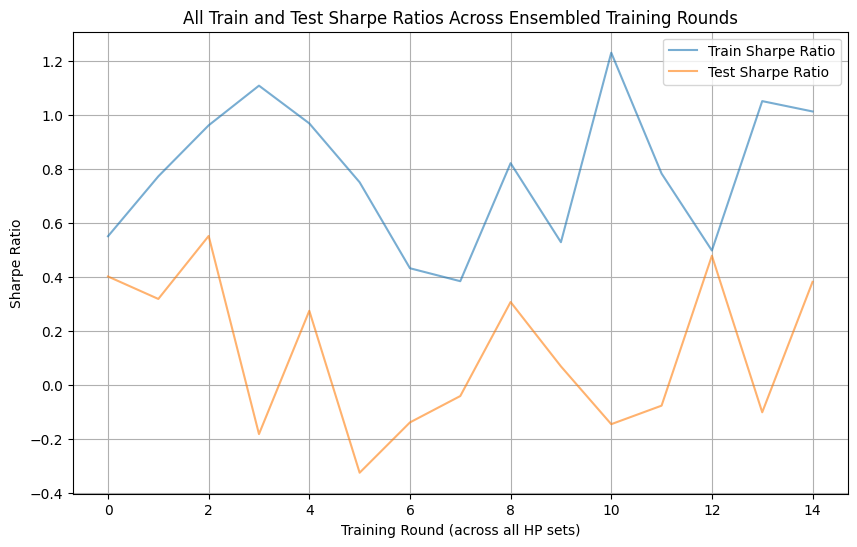

In [66]:
# Checking how output varies in each round

import matplotlib.pyplot as plt


train_sharpe_ratios = all_train_results['sharpe_ratio']
test_sharpe_ratios = all_test_results['sharpe_ratio']

plt.figure(figsize=(10, 6))
plt.plot(range(len(train_sharpe_ratios)), train_sharpe_ratios, label='Train Sharpe Ratio', alpha=0.6)
plt.plot(range(len(test_sharpe_ratios)), test_sharpe_ratios, label='Test Sharpe Ratio', alpha=0.6)

plt.xlabel('Training Round (across all HP sets)')
plt.ylabel('Sharpe Ratio')
plt.title('All Train and Test Sharpe Ratios Across Ensembled Training Rounds')
plt.legend()
plt.grid(True)
plt.show()

# Model Comparison and results

We compare our GAN based model output against baseline models like Fama-French model and Mean-Variance portfolio.

In [67]:
from baseline_models import fama_french_5, linear_mv
import numpy as np

num_runs = 15

ff_train_sharpes = []
ff_test_sharpes = []
mv_train_sharpes = []
mv_test_sharpes = []


for i in range(num_runs):

    # Evaluate Fama-French Baseline
    ff_results = fama_french_5(train_dataset, combined_val_test_dataset)
    ff_train_sharpes.append(ff_results['train_sharpe'])
    ff_test_sharpes.append(ff_results['test_sharpe'])

    # Evaluate Mean-Variance Baseline
    mv_results = linear_mv(train_dataset, combined_val_test_dataset)
    mv_train_sharpes.append(mv_results['train_sharpe'])
    mv_test_sharpes.append(mv_results['test_sharpe'])


print("\nSummary of Baseline Model Results (Average over 10 Runs):")
print("-" * 60)

# Fama-French Results
avg_ff_train_sharpe = np.mean(ff_train_sharpes)
std_ff_train_sharpe = np.std(ff_train_sharpes)
avg_ff_test_sharpe = np.mean(ff_test_sharpes)
std_ff_test_sharpe = np.std(ff_test_sharpes)

print("Fama-French 5-Factor Model:")
print(f"  Average Train Sharpe Ratio: {avg_ff_train_sharpe:.4f} (Std Dev: {std_ff_train_sharpe:.4f})")
print(f"  Average Test Sharpe Ratio: {avg_ff_test_sharpe:.4f} (Std Dev: {std_ff_test_sharpe:.4f})")
print("-" * 30)

# Mean-Variance Results
avg_mv_train_sharpe = np.mean(mv_train_sharpes)
std_mv_train_sharpe = np.std(mv_train_sharpes)
avg_mv_test_sharpe = np.mean(mv_test_sharpes)
std_mv_test_sharpe = np.std(mv_test_sharpes)

print("Linear Mean-Variance Portfolio:")
print(f"  Average Train Sharpe Ratio: {avg_mv_train_sharpe:.4f} (Std Dev: {std_mv_train_sharpe:.4f})")
print(f"  Average Test Sharpe Ratio: {avg_mv_test_sharpe:.4f} (Std Dev: {std_mv_test_sharpe:.4f})")
print("-" * 60)


Summary of Baseline Model Results (Average over 10 Runs):
------------------------------------------------------------
Fama-French 5-Factor Model:
  Average Train Sharpe Ratio: 0.2172 (Std Dev: 0.0135)
  Average Test Sharpe Ratio: -0.8057 (Std Dev: 0.0212)
------------------------------
Linear Mean-Variance Portfolio:
  Average Train Sharpe Ratio: 0.4020 (Std Dev: 0.0191)
  Average Test Sharpe Ratio: -0.7085 (Std Dev: 0.0239)
------------------------------------------------------------


# Results



Here is a table comparing the average Sharpe Ratios of the GAN model (ensembled results) with the Fama-French 5-Factor and Linear Mean-Variance baseline models on the training and combined validation/test datasets.

|             | **GAN (Ensembled)** | **Fama-French** | **Mean-Variance** |
|-------------|---------------------|-----------------|-------------------|
| **Train**   |  **0.79**  |  **0.22**  |  **0.40**  |
| **Test**    |  **0.12**   |  **-0.81**   |  **-0.71**   |



Here is a table showing the average Cross-sectional R² and Mean Absolute Pricing Error for the GAN model (ensembled results) on the training and combined validation/test datasets.

|             | **Cross-sectional R²** | **Mean Absolute Pricing Error** |
|-------------|------------------------|---------------------------------|
| **Train**   |  **-0.4481**           |  **0.044808**                   |
| **Test**    |  **-0.5270**           |  **0.085018**                   |

# TO DO:



1.   Since the models are very sensitive to initial weights, we can train generator and discriminator seperately first to stabilize the range of starting weights and then train them together. This is what the paper seems to be doing.  
2.   Plot 10 runs of the ensembled model to check if the results are statistically significant compared to baseline.
3. Add a seperate LSTM for Discriminator.
4. Try out on larger numbers of test portfolios
5. The variance of GAN model is still pretty high. May be train on larger number of models?

